In [9]:
import torch
from torch import nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from torchvision import transforms
from tqdm import tqdm
import torch.nn.functional as F

In [10]:
# import zipfile
# import os

# zip_file_path = '/content/drive/MyDrive/archive.zip'

# extract_dir = '/content/drive/MyDrive/'

# # Open the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# extracted_files = os.listdir(extract_dir)
# print("Extracted files:", extracted_files)

In [11]:
BATCH_SIZE = 16
LATENT_DIM = 256
MAX_BLOCKS = 6
ALPHA_START = 1 / MAX_BLOCKS
STEPS_FOR_BLOCK = 10

In [12]:
ALPHA_START

0.16666666666666666

In [13]:
def generate_noise():
  return torch.rand(LATENT_DIM)

def generate_noise_batch():
  return torch.rand((BATCH_SIZE, LATENT_DIM))

def generate_image():
  return torch.rand((32, 512, 32, 32))

In [14]:
class NearestNeighborFilter(nn.Module):
    def __init__(self, scale_factor):
        super(NearestNeighborFilter, self).__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor, mode='nearest')

In [15]:
class GeneratorBlock(nn.Module):
    def __init__(self, inp, out, kernel=2, stride=2, padding=0):
        super().__init__()

        self.transpose = nn.Sequential(
            NearestNeighborFilter(2),
            nn.Conv2d(inp, out, 3, padding=1),
            nn.BatchNorm2d(out),
            nn.LeakyReLU(),
        )

        self.conv = nn.Sequential(
            nn.Conv2d(inp, out, 3, padding=1),
            nn.BatchNorm2d(out),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        transposed = self.transpose(x)
        after_convolution = self.conv(transposed)
        return transposed, after_convolution


In [16]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.init_blocks = nn.Sequential(
            nn.Linear(LATENT_DIM, 4*4*256),
            nn.BatchNorm1d(4*4*256),
            nn.LeakyReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
        )
        
        self.alpha = 0

        self.tanh = nn.Tanh()

        self.generator_blocks = nn.ModuleList()

        self.torgb1 = nn.Conv2d(256, 3, kernel_size=1, stride=1, padding=0)
        self.torgb2 = nn.Conv2d(256, 3, kernel_size=1, stride=1, padding=0)


        self.add_block(GeneratorBlock(256, 256))

    def add_block(self, block: GeneratorBlock):
        self.generator_blocks.append(block)
        self.alpha += ALPHA_START
        self.torgb1.reset_parameters()
        self.torgb2.reset_parameters()

    def forward(self, x):
        out = self.init_blocks(x)

        if len(self.generator_blocks) == 1:
          out = self.torgb1(out)
          return self.tanh(out)

        counter = 0
        for generator_block in self.generator_blocks:
            if counter == len(self.generator_blocks) - 1:
                fs_rgbed = self.torgb1(out) * (1 - self.alpha)
                sc_rgbed = self.torgb2(after_conv)
                out = sc_rgbed * self.alpha + fs_rgbed
            else:
                out, after_conv = generator_block(out)
            counter += 1

        return self.tanh(out)


In [17]:
class DiscriminatorBlock(nn.Module):
  def __init__(self, inp, out, kernel=3, stride=1, padding=1, pooling_size=2):
    super().__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(inp, out, kernel, stride, padding),
        nn.InstanceNorm2d(out),
        nn.LeakyReLU(),
        nn.Conv2d(inp, out, kernel, stride, padding),
        nn.InstanceNorm2d(out),
        nn.LeakyReLU(),
        nn.AvgPool2d(pooling_size)
    )
  def forward(self, x):
    return self.conv(x)

In [18]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.from_rgb = nn.Conv2d(3, 256, kernel_size=1, stride=1, padding=0)
    
    self.residual = nn.Sequential(
        nn.AvgPool2d(2),
        nn.Conv2d(3, 256, kernel_size=1, stride=1, padding=0),
        nn.InstanceNorm2d(256),
        nn.LeakyReLU(),
    )

    self.alpha = 0

    self.discriminator_blocks = nn.ModuleList()
    self.add_block(DiscriminatorBlock(256, 256))

    self.final_head = nn.Sequential(
      nn.Flatten(),
      nn.Linear(1024, 1),
    )

  def add_block(self, block: DiscriminatorBlock):
    self.discriminator_blocks.insert(0, block)
    self.alpha += ALPHA_START
    self.from_rgb.reset_parameters()
    for layer in self.residual.children():
      if hasattr(layer, 'reset_parameters'):
          layer.reset_parameters()

  def forward(self, x):
    residual = self.residual(x)
    from_rgb = self.from_rgb(x)
    from_rgb = self.discriminator_blocks[0](from_rgb)
    out = (residual * (1 - self.alpha)) + from_rgb * self.alpha
    
    if len(self.discriminator_blocks) > 1:
      for i in range(1, len(self.discriminator_blocks)):
        out = self.discriminator_blocks[i](out)
    
    out = self.final_head(out)
    return out
    # out = x
    # if len(self.discriminator_blocks) == 1:
    #   out = self.from_rgb(out)
    #   print(out.shape)
    #   return self.final_head(out)

    # counter = 0
    # for discriminator_block in self.discriminator_blocks:
    #   if counter == 0:
    #     print(out.shape)
    #     temp = out.clone()
    #     temp = self.residual(temp)
    #     out = self.from_rgb(out)
    #     out = discriminator_block(out)
    #     out = out * self.alpha + temp * (1 - self.alpha)
    #   else:
    #     print(out.shape)
    #     out = discriminator_block(out)
    #   counter += 1

    # return self.final_head(out)


In [19]:
gen = Generator()

In [12]:
gen_blocks = [GeneratorBlock(256, 256) for i in range(1, 4)]

In [13]:
for b in gen_blocks:
  gen.add_block(b)

In [14]:
len(gen_blocks)

3

In [20]:
test = generate_noise_batch()
disc_test = gen(test)

In [16]:
disc_test.shape

torch.Size([16, 3, 32, 32])

In [21]:
dis = Discriminator()

In [18]:
disc_blocks = [DiscriminatorBlock(256, 256) for i in range(1, 4)]

In [19]:
for d in disc_blocks:
  dis.add_block(d)

In [22]:
dis(disc_test)

tensor([[ 0.1412],
        [-0.0213],
        [ 0.0324],
        [-0.0726],
        [ 0.0996],
        [-0.2987],
        [ 0.2753],
        [ 0.0990],
        [-0.1615],
        [-0.0226],
        [ 0.1612],
        [ 0.1691],
        [ 0.4131],
        [-0.0550],
        [-0.0974],
        [ 0.0666]], grad_fn=<AddmmBackward0>)

In [23]:
class CelebADataset(Dataset):
    def __init__(self, root_dir):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.root_dir = root_dir
        self.image_list = os.listdir(root_dir)
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_list[idx])
        image = Image.open(img_name)
        image = transforms.ToTensor()(image)
        return image.to(self.device)

data_dir = './celeba_hq_256'

celeba_dataset = CelebADataset(root_dir=data_dir)

celeba_dataloader = DataLoader(celeba_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [24]:
x = next(iter(celeba_dataloader))
x[0]

tensor([[[0.9176, 0.9176, 0.9176,  ..., 0.9490, 0.9490, 0.9490],
         [0.9176, 0.9176, 0.9176,  ..., 0.9490, 0.9490, 0.9490],
         [0.9176, 0.9176, 0.9176,  ..., 0.9490, 0.9490, 0.9490],
         ...,
         [0.6314, 0.6627, 0.6902,  ..., 0.7569, 0.8039, 0.9216],
         [0.6784, 0.6941, 0.7176,  ..., 0.7608, 0.7843, 0.9176],
         [0.7294, 0.7020, 0.7137,  ..., 0.7804, 0.8000, 0.9529]],

        [[0.9020, 0.9020, 0.9020,  ..., 0.9451, 0.9451, 0.9451],
         [0.9020, 0.9020, 0.9020,  ..., 0.9451, 0.9451, 0.9451],
         [0.9020, 0.9020, 0.9020,  ..., 0.9451, 0.9451, 0.9451],
         ...,
         [0.3922, 0.4314, 0.4706,  ..., 0.6039, 0.6471, 0.7765],
         [0.4392, 0.4627, 0.5059,  ..., 0.6078, 0.6314, 0.7608],
         [0.4824, 0.4706, 0.5020,  ..., 0.6235, 0.6471, 0.7961]],

        [[0.8902, 0.8902, 0.8902,  ..., 0.9294, 0.9294, 0.9294],
         [0.8902, 0.8902, 0.8902,  ..., 0.9294, 0.9294, 0.9294],
         [0.8902, 0.8902, 0.8902,  ..., 0.9294, 0.9294, 0.

In [33]:
class PGAN:
  def __init__(self, dataloader, max_blocks=6, steps_for_next_block=10, epochs=100):
     self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
     print(self.device)

     self.transform_wh = 4
     
     self.resize = transforms.Compose([
       transforms.Resize((self.transform_wh, self.transform_wh))
     ])

     self.max_blocks = max_blocks
     self.steps_for_next_block = steps_for_next_block
     self.epochs = epochs

     self.generator = Generator().to(self.device)
     self.discriminator = Discriminator().to(self.device)

     self.next_generator_blocks = [GeneratorBlock(256, 256) for _ in range(1, self.max_blocks + 1)]
     self.next_disc_blocks = [DiscriminatorBlock(256, 256) for _ in range(1, self.max_blocks + 1)]

     self.optimizer_G = Adam(self.generator.parameters(), lr=0.001, betas=(0.0, 0.99))
     self.optimizer_D = Adam(self.discriminator.parameters(), lr=0.001, betas=(0.0, 0.99))

     self.dataloader = dataloader
     
     self.add = True

  def set_new_transform(self):
    self.transform_wh *= 2
    self.resize = transforms.Compose([
      transforms.Resize((self.transform_wh, self.transform_wh)),
    ])

  def train(self):
    generator_losses = []
    discriminator_losses = []
    
    for epoch in range(self.epochs):
      for real_images in tqdm(self.dataloader):
        real_images = self.resize(real_images)
        self.optimizer_D.zero_grad()

        noise = generate_noise_batch().to(self.device)
        
        fake_images = self.generator(noise)
        fake_logits = self.discriminator(fake_images.detach())
        real_logits = self.discriminator(real_images)

        d_loss_real = -torch.mean(real_logits)
        d_loss_fake = torch.mean(fake_logits)
        d_loss = d_loss_real + d_loss_fake

        d_loss.backward(retain_graph=True)
        
        self.optimizer_D.step()

        # GENERATOR

        self.optimizer_G.zero_grad()
        
        noise = generate_noise_batch().to(self.device)
        fake_images = self.generator(noise)
        fake_logits = self.discriminator(fake_images)
        g_loss = -torch.mean(fake_logits)
        g_loss.backward()
        
        self.optimizer_G.step()

      generator_losses.append(g_loss.item())
      discriminator_losses.append(d_loss.item())
      
      print(f"EPOCH {epoch} || GENERATOR LOSS: {g_loss.item()} || DISCRIMINATOR LOSS: {d_loss.item()}")
      
      self.sample()
      self.show_real()

      if epoch > 0 and epoch % self.steps_for_next_block == 0 and len(self.next_generator_blocks) != 0:
        print("EXTENDED")
        self.generator.add_block(self.next_generator_blocks.pop().to(self.device))
        self.discriminator.add_block(self.next_disc_blocks.pop().to(self.device))
        self.set_new_transform()
      
      torch.save(self.generator.state_dict, "generator3.h5")
      torch.save(self.discriminator.state_dict, "discriminator3.h5")
      
      plt.figure(figsize=(10, 5))
      plt.plot(generator_losses, label='Generator Loss')
      plt.plot(discriminator_losses, label='Discriminator Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.title('Generator and Discriminator Losses')
      plt.legend()
      plt.show()

  def compute_gradient_penalty(self, real_images, fake_images):
    batch_size = real_images.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1).to(self.device)
    interpolated_images = epsilon * real_images + (1 - epsilon) * fake_images

    critic_scores = self.discriminator(interpolated_images)

    gradients = torch.autograd.grad(
      inputs=interpolated_images,
      outputs=critic_scores,
      grad_outputs=torch.ones_like(critic_scores),
      create_graph=True,
      retain_graph=True,
      only_inputs=True,
    )[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty

  def sample(self):
    r, c = 4, 4
    gen_imgs = self.generator(generate_noise_batch().to(self.device))
    gen_imgs = gen_imgs.permute(0, 2, 3, 1).detach().cpu().numpy()
    gen_imgs = 0.5*gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    
  def show_real(self):
    for i, batch in enumerate(self.dataloader):
      images = batch[:16]
      images = self.resize(images)
      images = images.permute(0, 2, 3, 1)
      images = images.cpu().numpy()

      fig, axes = plt.subplots(4, 4)
      for j, ax in enumerate(axes.flat):
          ax.imshow(images[j])
          ax.axis('off')
          ax.set_title(f'Real {j+1}')
      plt.show()

      break

cuda


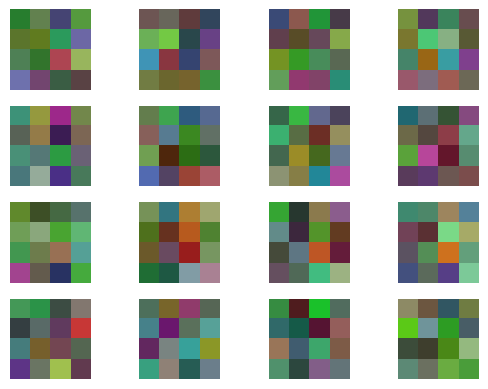

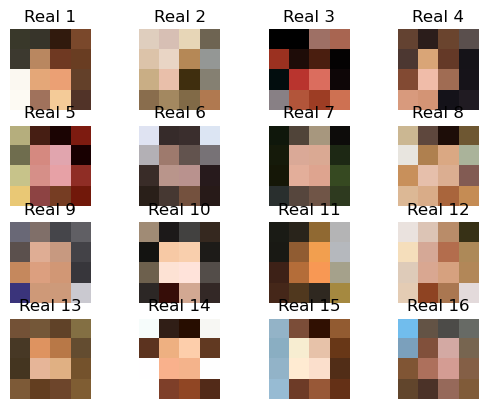

In [34]:
pgan = PGAN(celeba_dataloader)
pgan.sample()
pgan.show_real()

100%|██████████| 1875/1875 [01:00<00:00, 31.22it/s]


EPOCH 0 || GENERATOR LOSS: 9.207204818725586 || DISCRIMINATOR LOSS: -2.304187297821045


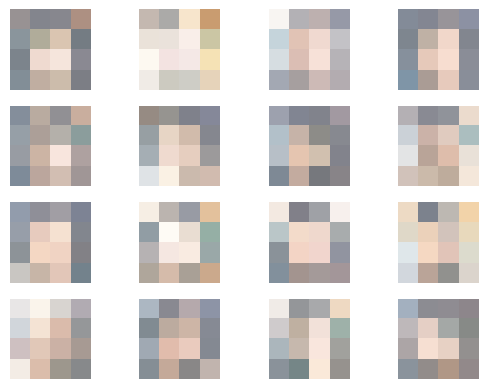

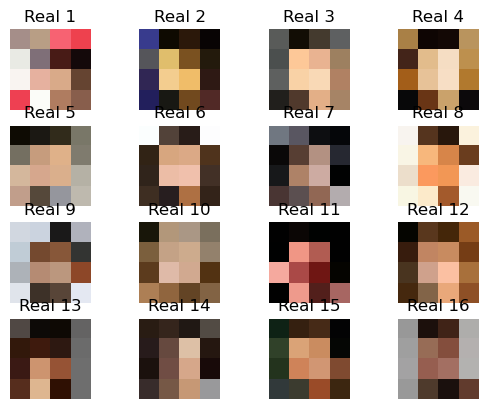

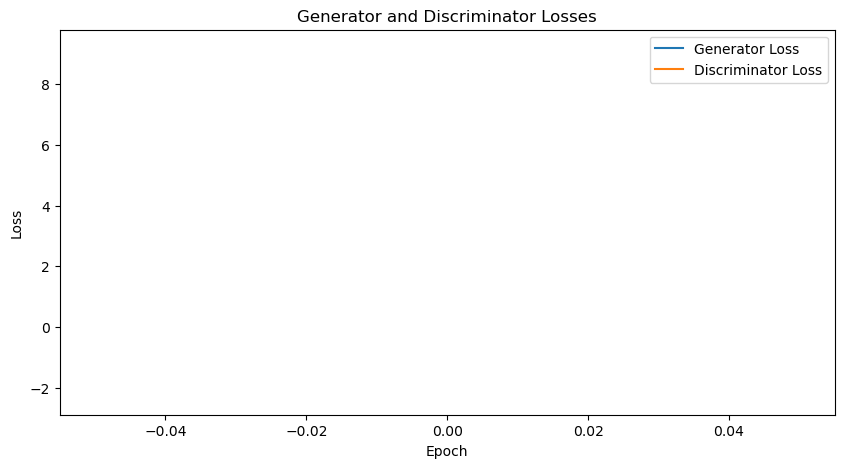

100%|██████████| 1875/1875 [00:59<00:00, 31.33it/s]


EPOCH 1 || GENERATOR LOSS: 2.125486373901367 || DISCRIMINATOR LOSS: -2.100311517715454


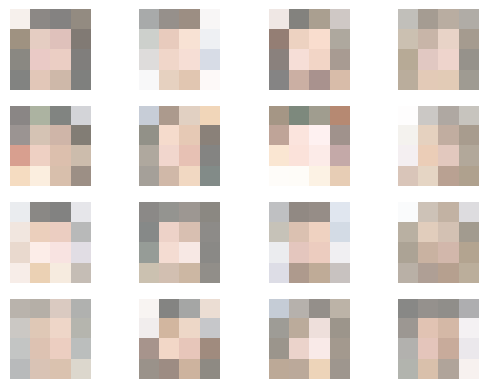

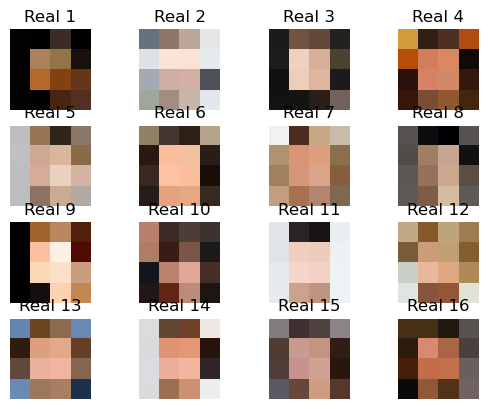

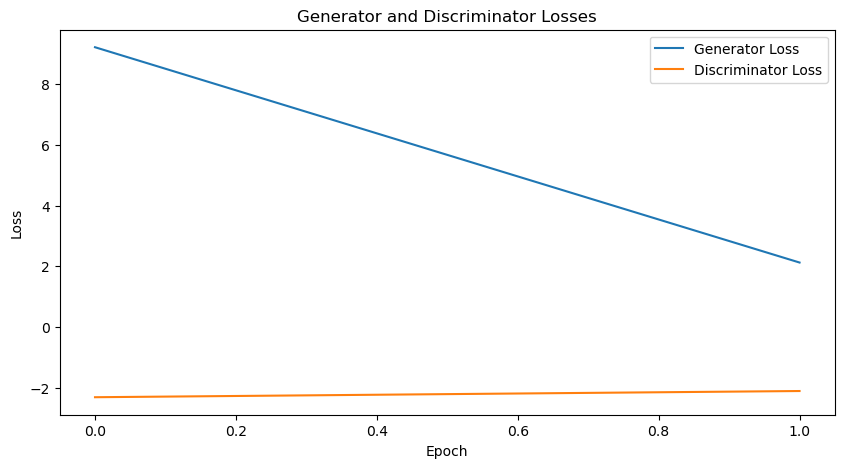

100%|██████████| 1875/1875 [01:00<00:00, 30.97it/s]


EPOCH 2 || GENERATOR LOSS: -1.2312266826629639 || DISCRIMINATOR LOSS: -1.3505067825317383


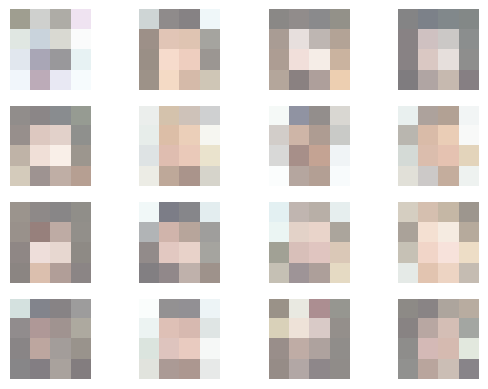

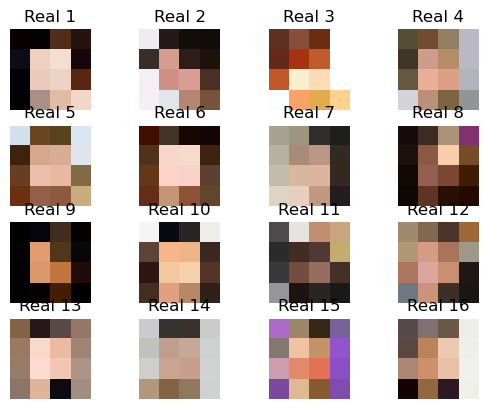

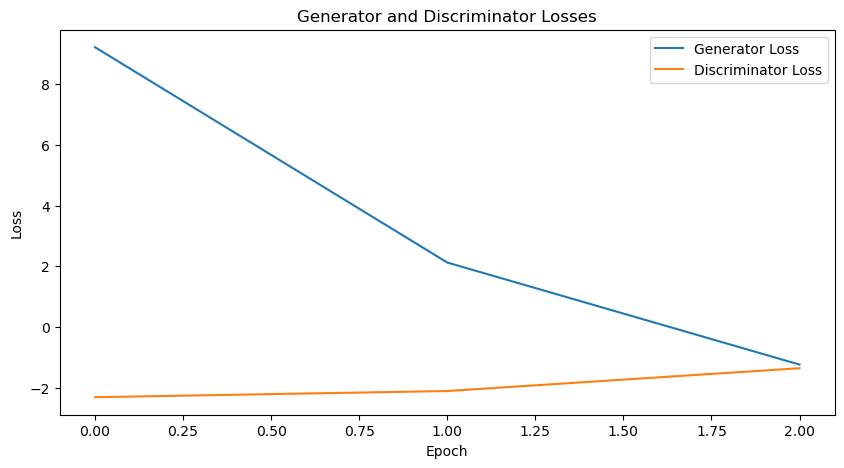

100%|██████████| 1875/1875 [00:59<00:00, 31.42it/s]


EPOCH 3 || GENERATOR LOSS: -1.2751991748809814 || DISCRIMINATOR LOSS: 3.399156332015991


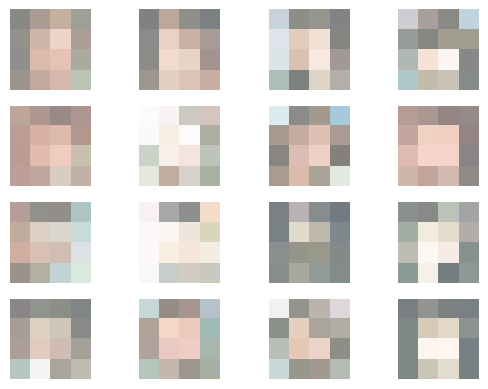

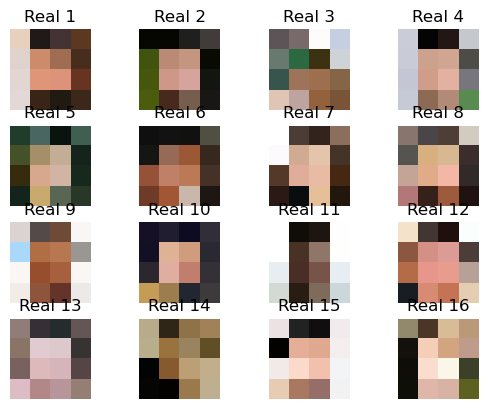

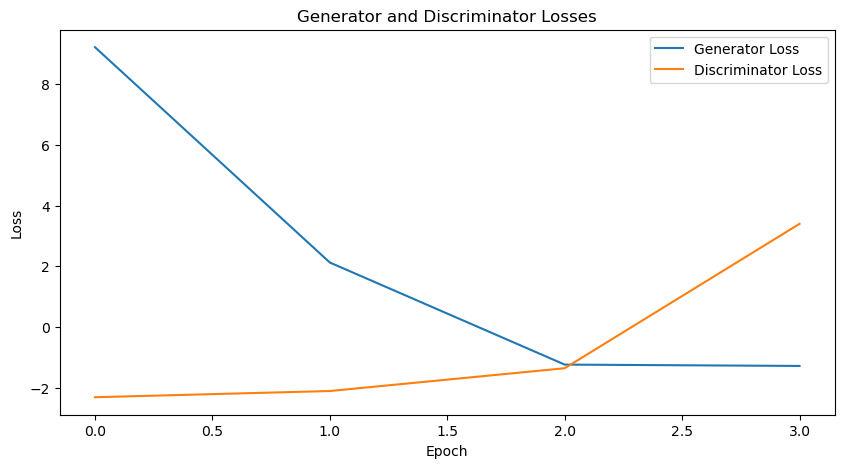

100%|██████████| 1875/1875 [01:00<00:00, 30.86it/s]


EPOCH 4 || GENERATOR LOSS: -2.2061469554901123 || DISCRIMINATOR LOSS: -4.654999256134033


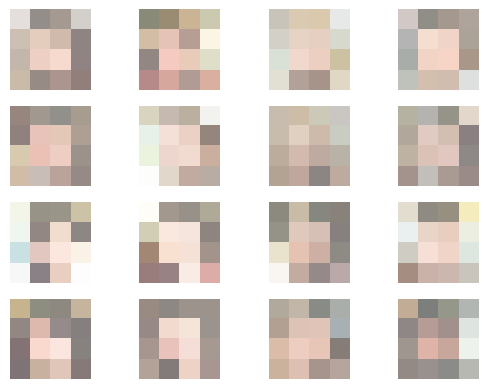

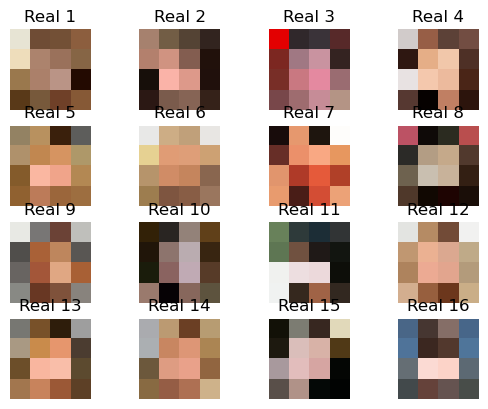

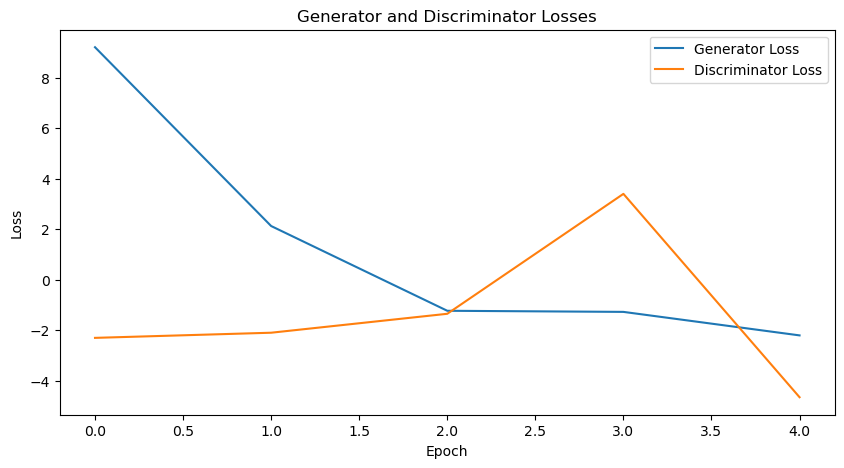

100%|██████████| 1875/1875 [01:00<00:00, 31.12it/s]


EPOCH 5 || GENERATOR LOSS: -1.6220567226409912 || DISCRIMINATOR LOSS: 2.331051826477051


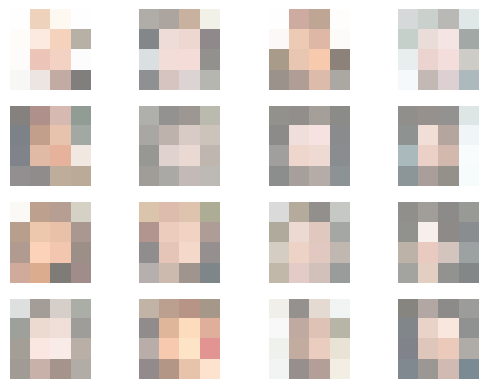

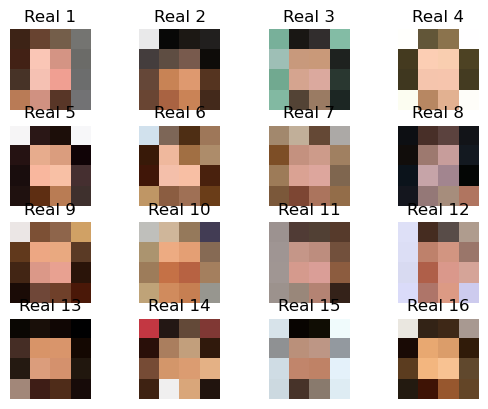

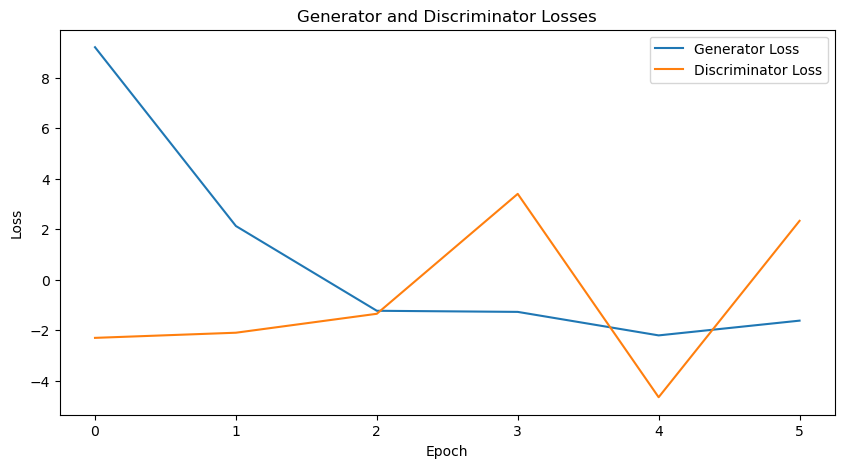

100%|██████████| 1875/1875 [01:01<00:00, 30.72it/s]


EPOCH 6 || GENERATOR LOSS: -18.015897750854492 || DISCRIMINATOR LOSS: 1.8583965301513672


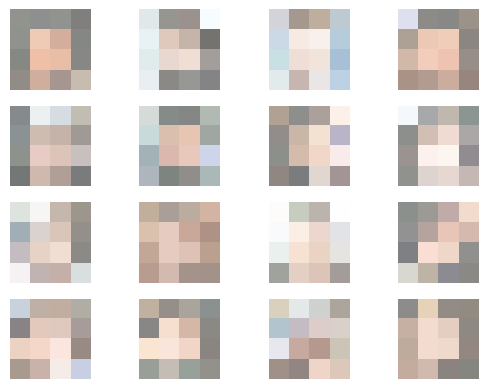

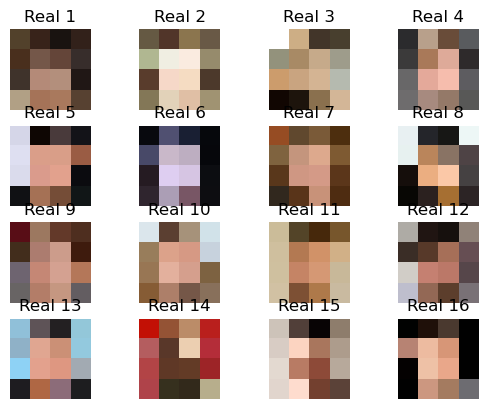

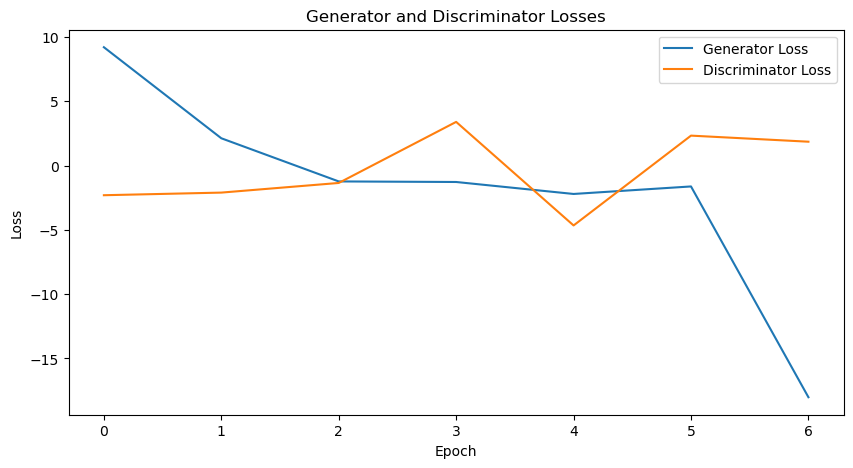

100%|██████████| 1875/1875 [01:02<00:00, 30.11it/s]


EPOCH 7 || GENERATOR LOSS: -7.163354396820068 || DISCRIMINATOR LOSS: 0.15889596939086914


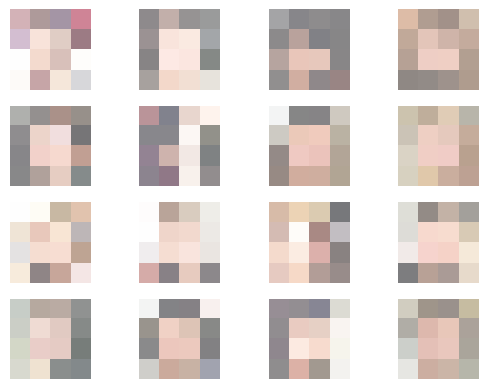

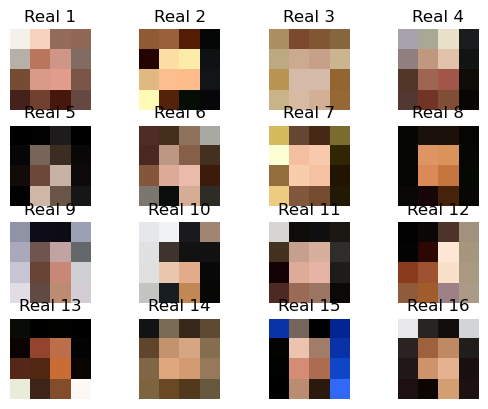

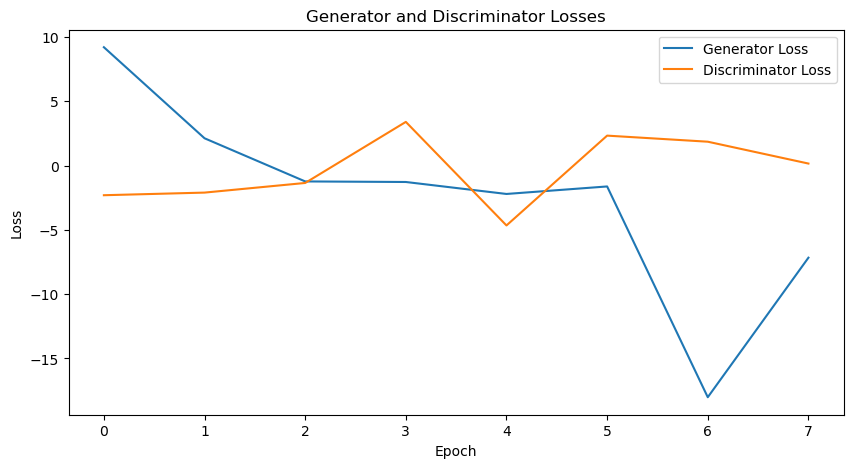

100%|██████████| 1875/1875 [01:00<00:00, 30.97it/s]


EPOCH 8 || GENERATOR LOSS: -11.170215606689453 || DISCRIMINATOR LOSS: 2.842853546142578


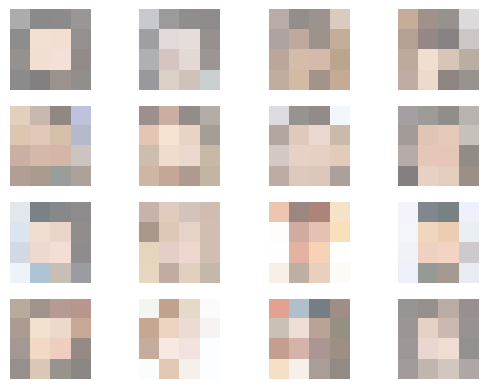

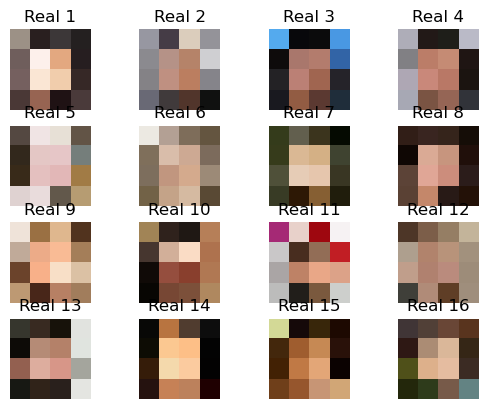

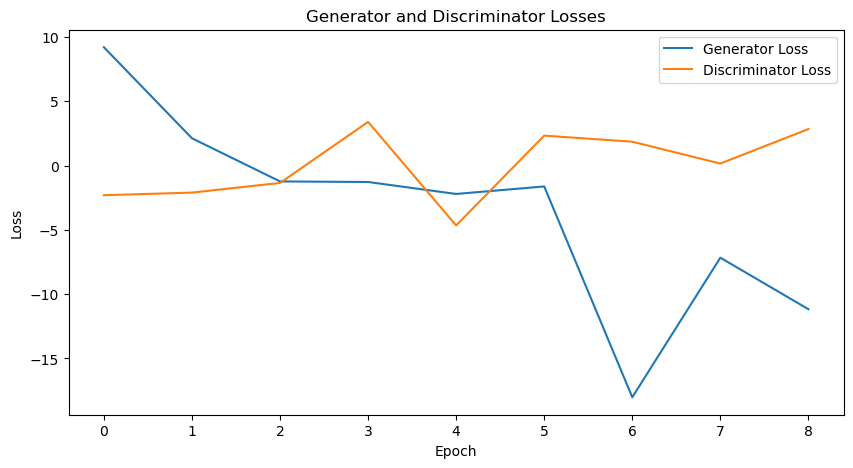

100%|██████████| 1875/1875 [01:00<00:00, 30.84it/s]


EPOCH 9 || GENERATOR LOSS: -8.194765090942383 || DISCRIMINATOR LOSS: -1.2662181854248047


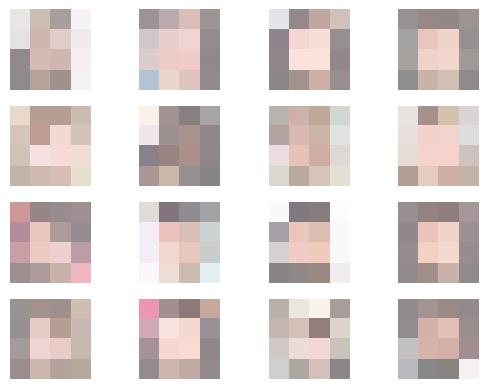

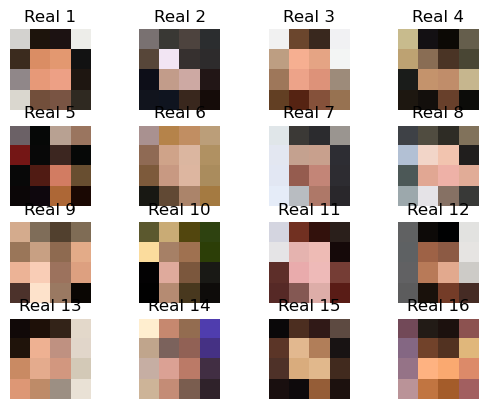

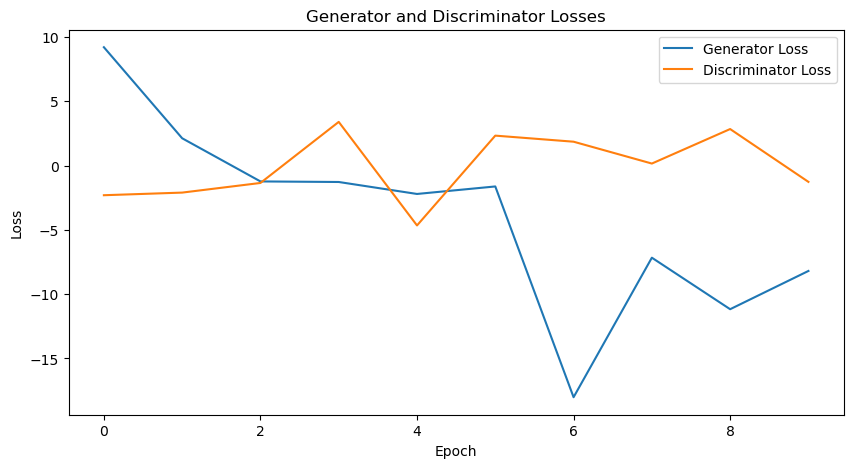

100%|██████████| 1875/1875 [01:00<00:00, 31.01it/s]


EPOCH 10 || GENERATOR LOSS: -19.23771095275879 || DISCRIMINATOR LOSS: -1.1262950897216797


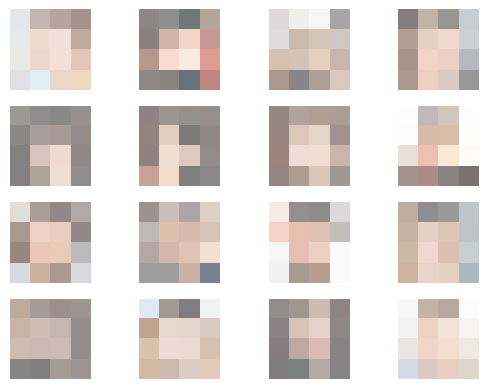

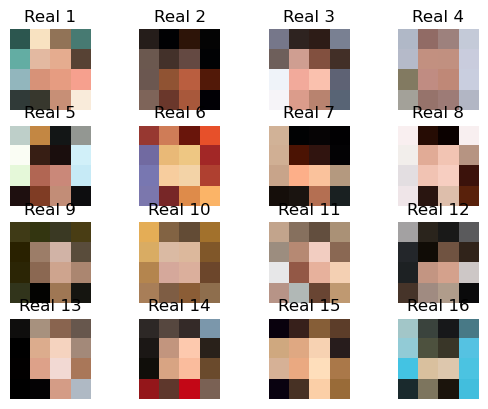

EXTENDED


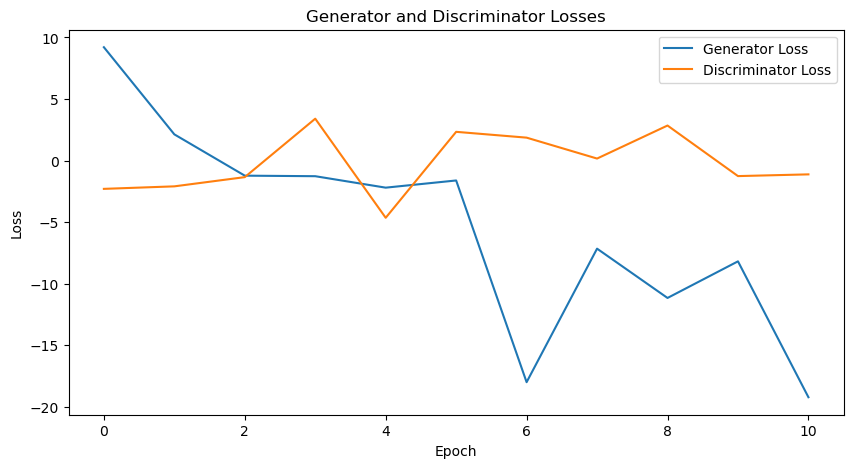

100%|██████████| 1875/1875 [01:06<00:00, 28.14it/s]


EPOCH 11 || GENERATOR LOSS: -273.19769287109375 || DISCRIMINATOR LOSS: 1.602996826171875


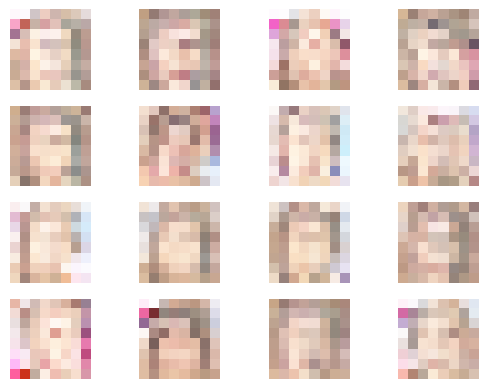

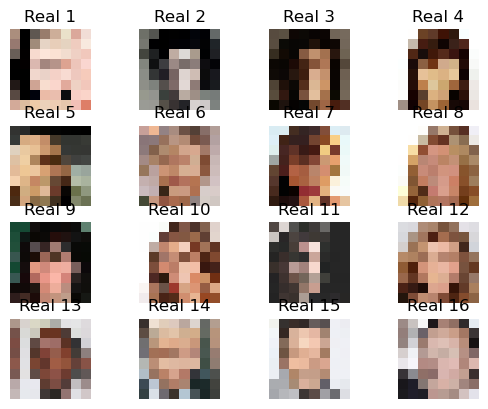

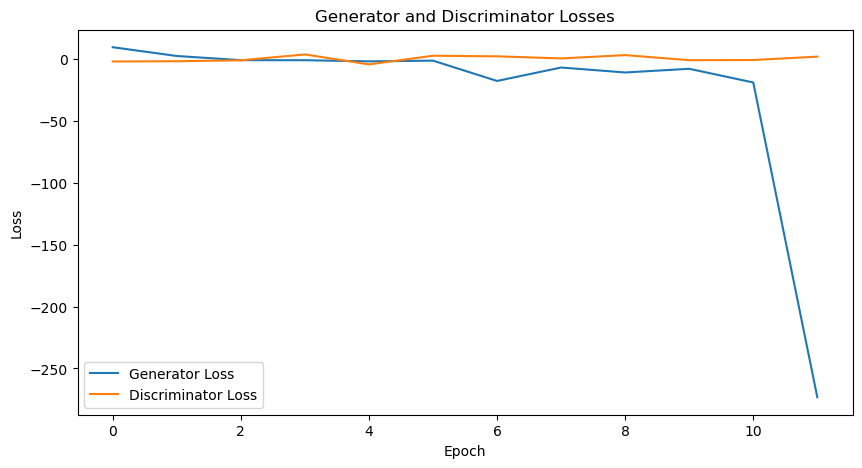

100%|██████████| 1875/1875 [01:06<00:00, 28.36it/s]


EPOCH 12 || GENERATOR LOSS: -218.84422302246094 || DISCRIMINATOR LOSS: 0.3226470947265625


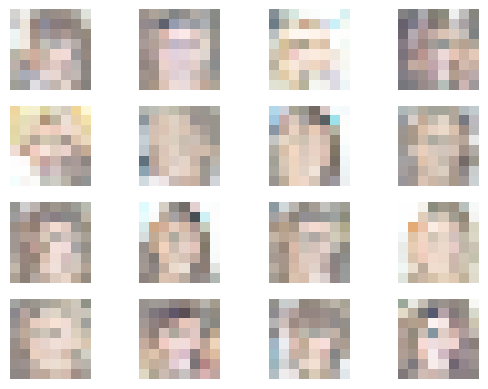

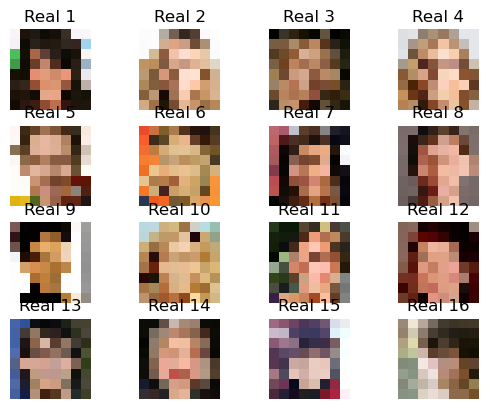

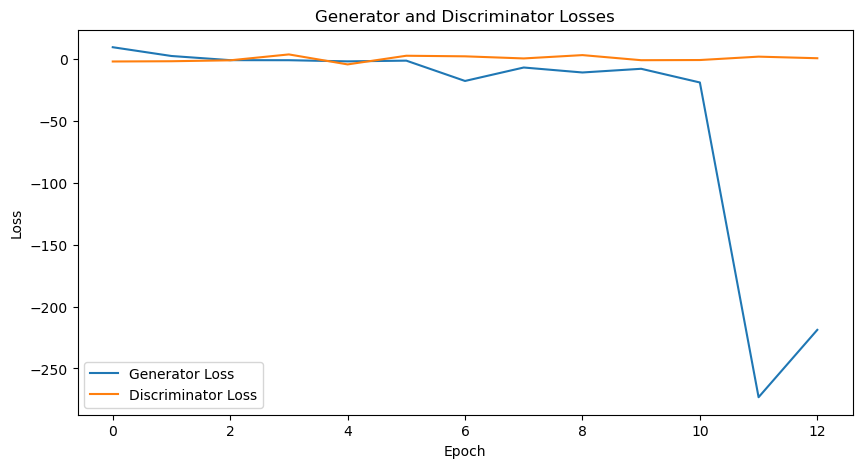

100%|██████████| 1875/1875 [01:06<00:00, 28.18it/s]


EPOCH 13 || GENERATOR LOSS: -183.65036010742188 || DISCRIMINATOR LOSS: 0.08929443359375


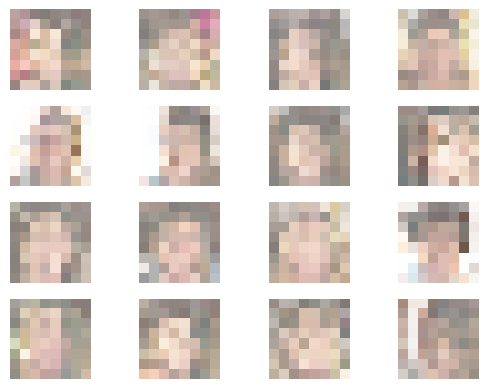

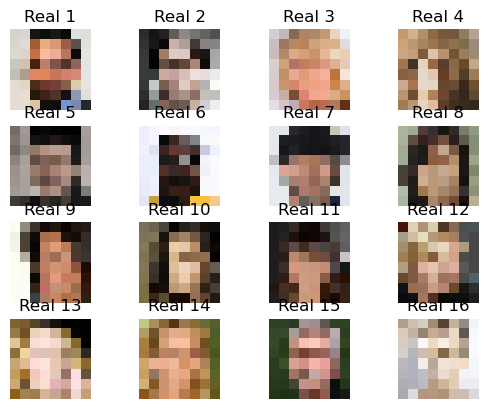

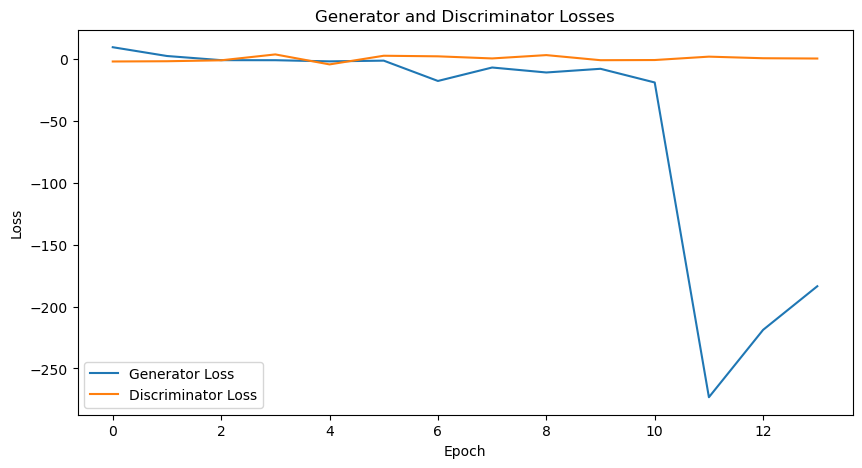

100%|██████████| 1875/1875 [01:06<00:00, 28.15it/s]


EPOCH 14 || GENERATOR LOSS: -163.04559326171875 || DISCRIMINATOR LOSS: 0.248870849609375


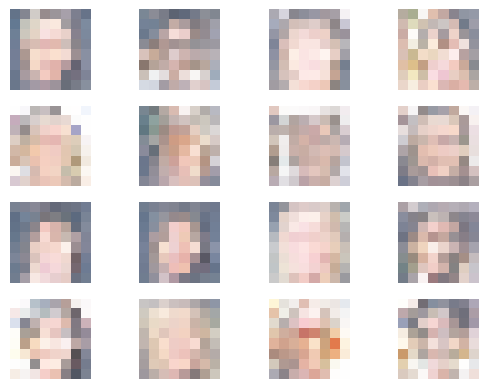

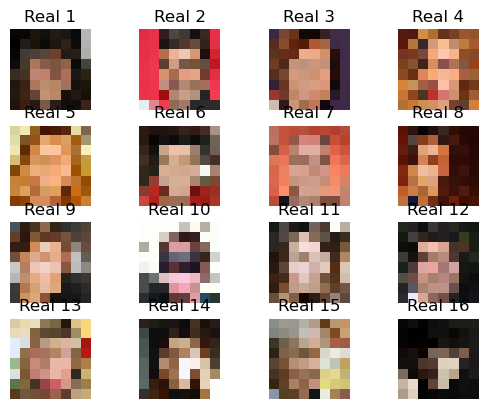

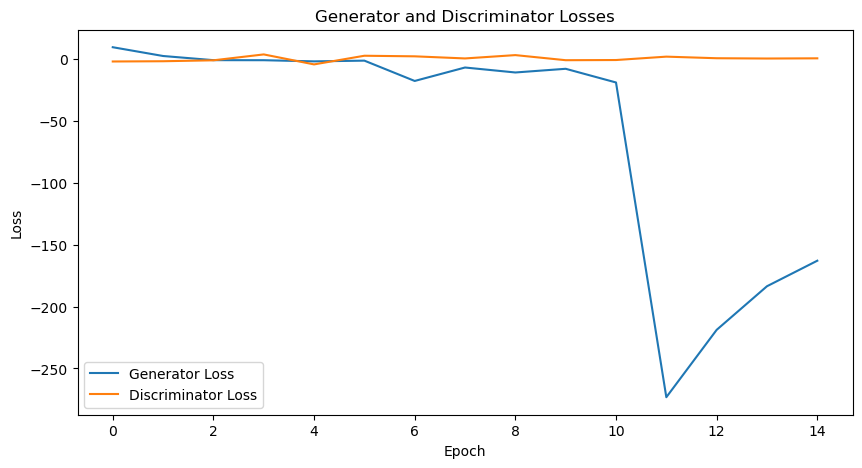

100%|██████████| 1875/1875 [01:06<00:00, 28.27it/s]


EPOCH 15 || GENERATOR LOSS: -150.65354919433594 || DISCRIMINATOR LOSS: -0.047119140625


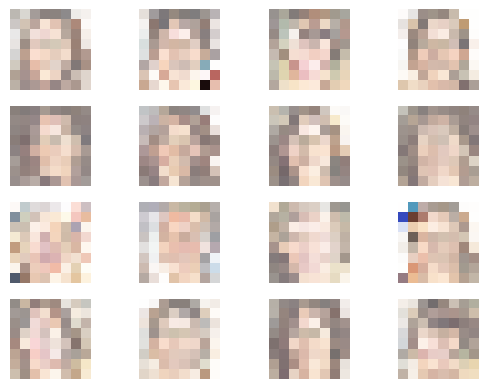

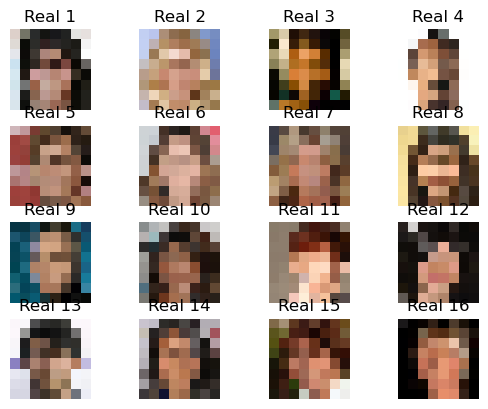

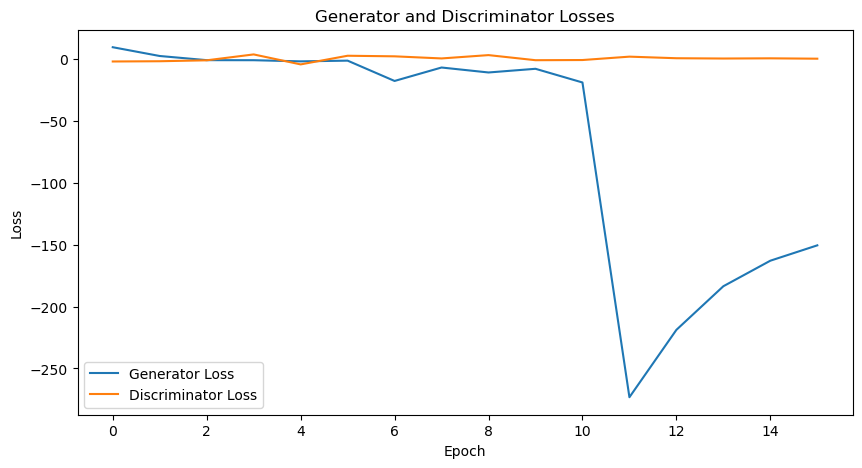

100%|██████████| 1875/1875 [01:06<00:00, 28.14it/s]


EPOCH 16 || GENERATOR LOSS: -144.9964599609375 || DISCRIMINATOR LOSS: 0.062652587890625


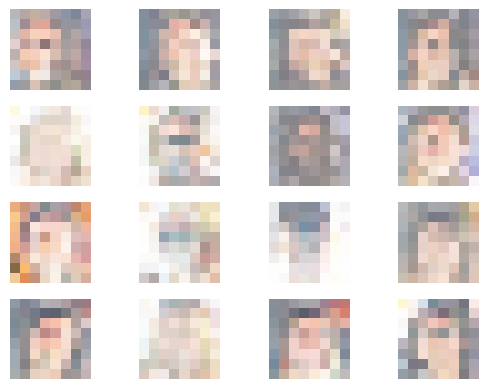

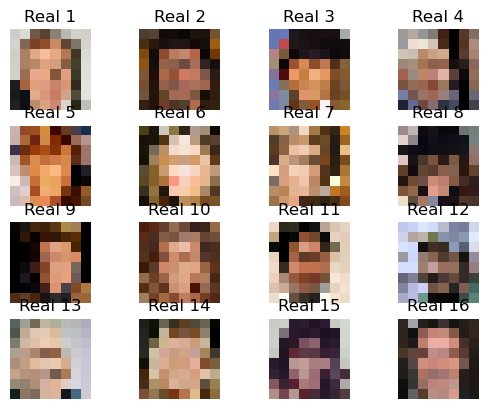

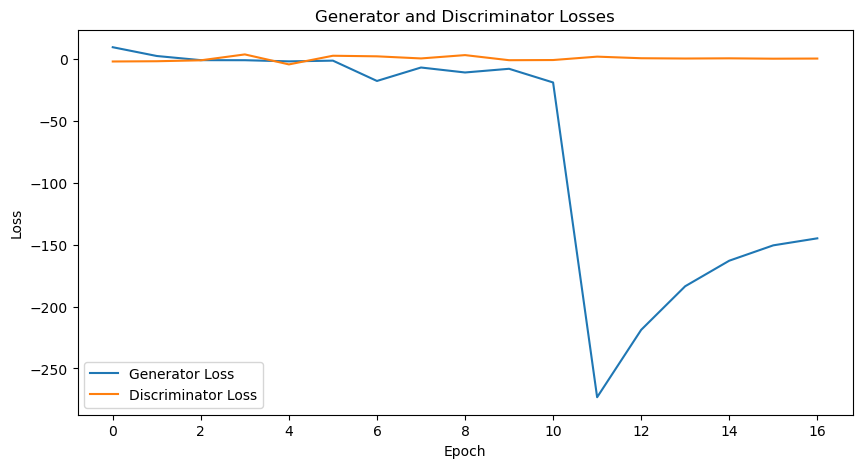

100%|██████████| 1875/1875 [01:06<00:00, 28.17it/s]


EPOCH 17 || GENERATOR LOSS: -138.48890686035156 || DISCRIMINATOR LOSS: 0.20257568359375


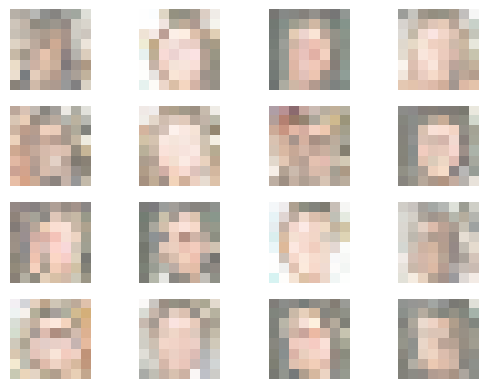

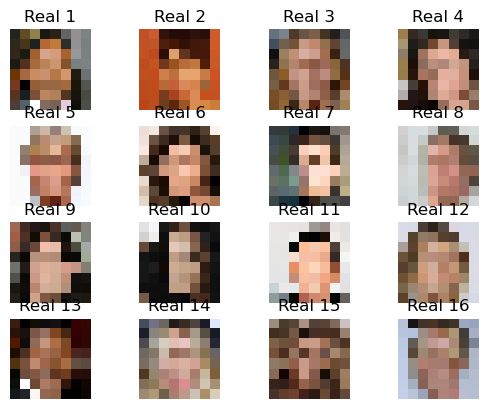

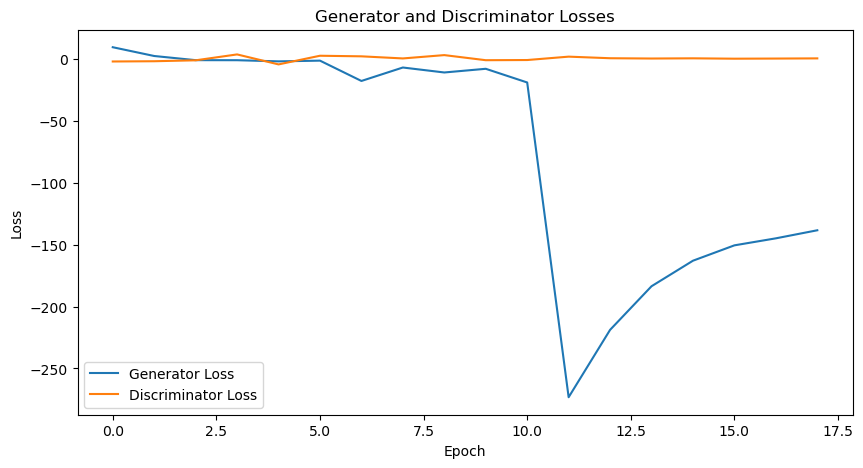

100%|██████████| 1875/1875 [01:06<00:00, 28.22it/s]


EPOCH 18 || GENERATOR LOSS: -133.831787109375 || DISCRIMINATOR LOSS: -0.09246826171875


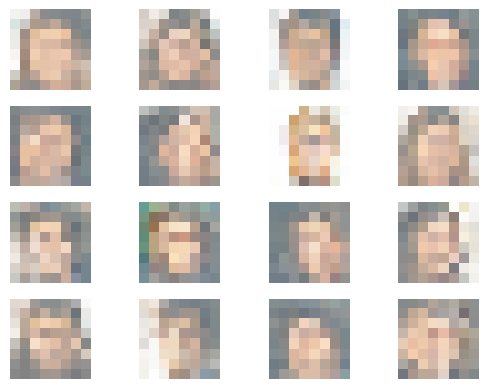

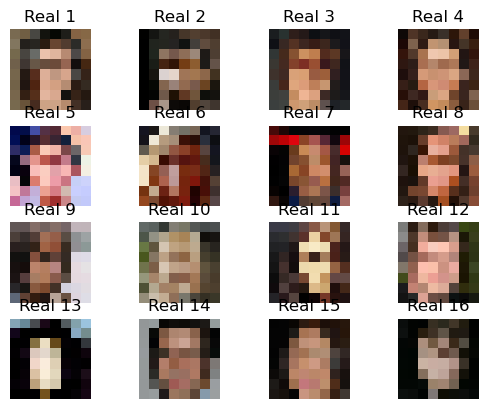

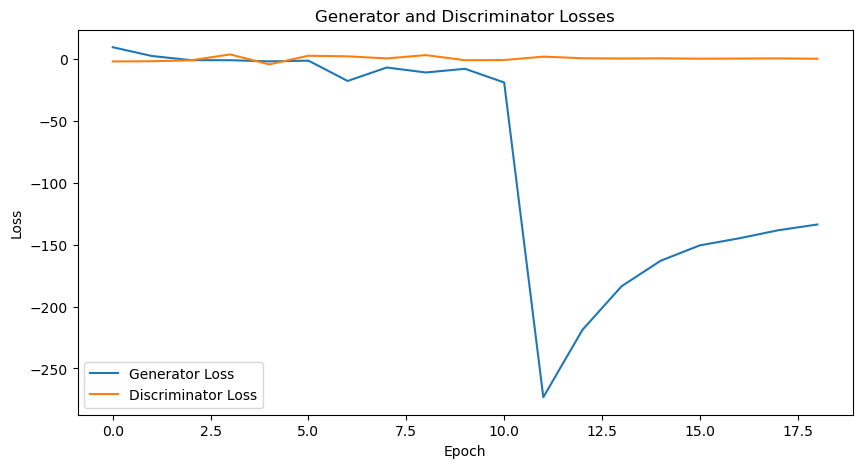

100%|██████████| 1875/1875 [01:06<00:00, 28.22it/s]


EPOCH 19 || GENERATOR LOSS: -130.71633911132812 || DISCRIMINATOR LOSS: 0.301361083984375


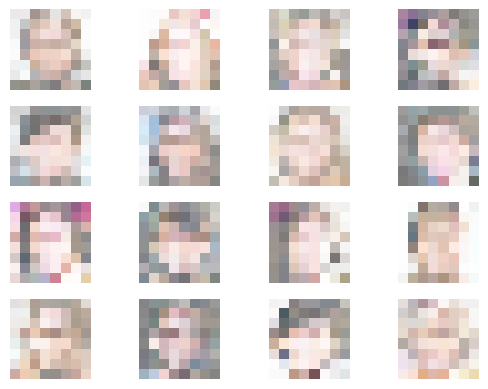

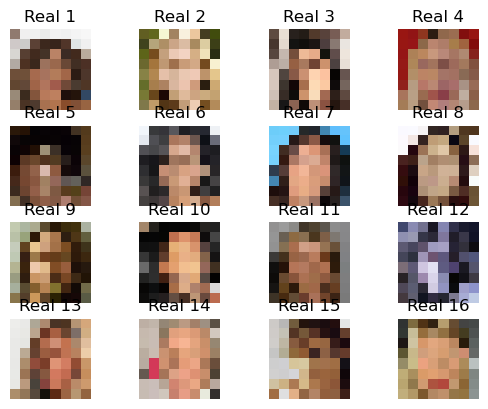

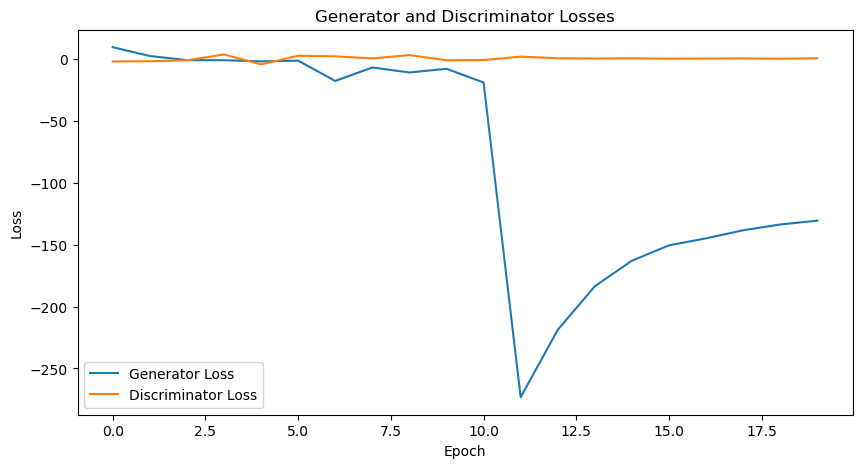

100%|██████████| 1875/1875 [01:06<00:00, 28.05it/s]


EPOCH 20 || GENERATOR LOSS: -128.40567016601562 || DISCRIMINATOR LOSS: 0.3921966552734375


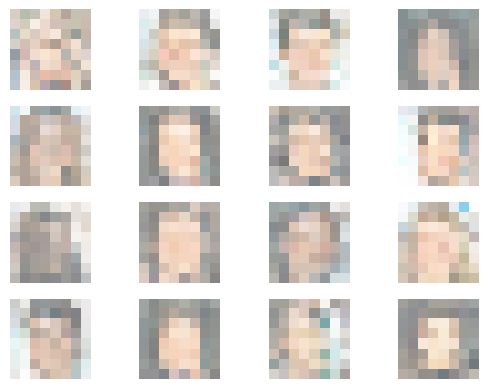

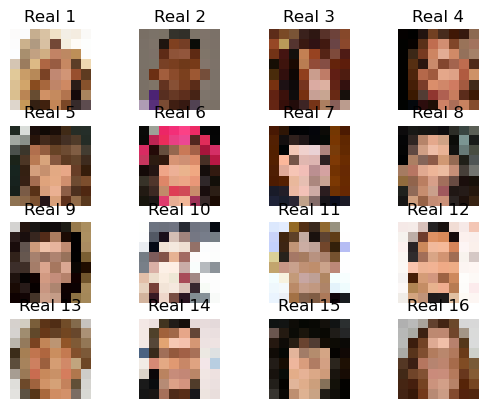

EXTENDED


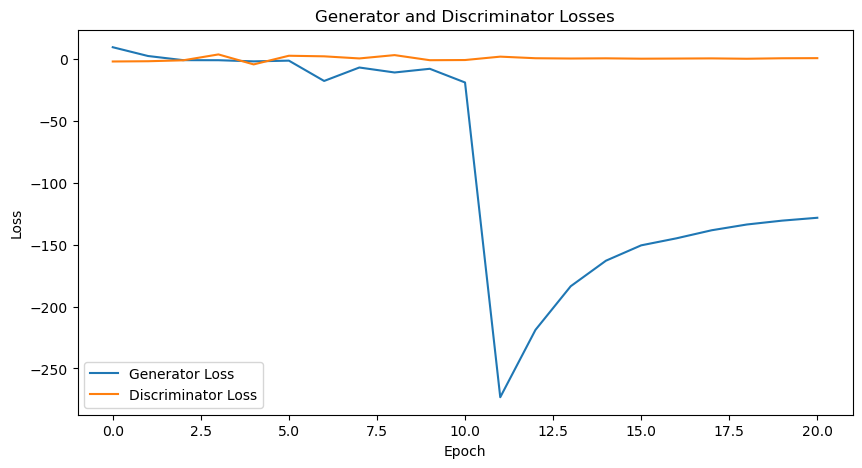

100%|██████████| 1875/1875 [01:22<00:00, 22.77it/s]


EPOCH 21 || GENERATOR LOSS: 265.97052001953125 || DISCRIMINATOR LOSS: -185.32017517089844


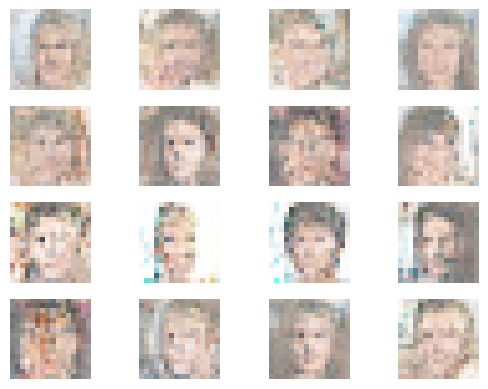

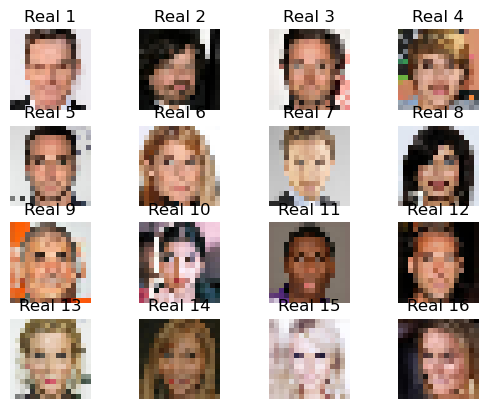

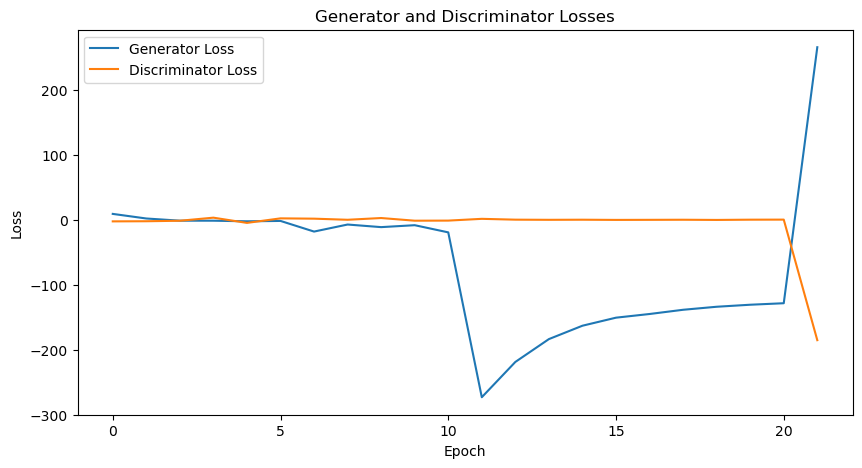

100%|██████████| 1875/1875 [01:22<00:00, 22.73it/s]


EPOCH 22 || GENERATOR LOSS: 884.2120361328125 || DISCRIMINATOR LOSS: -454.0286865234375


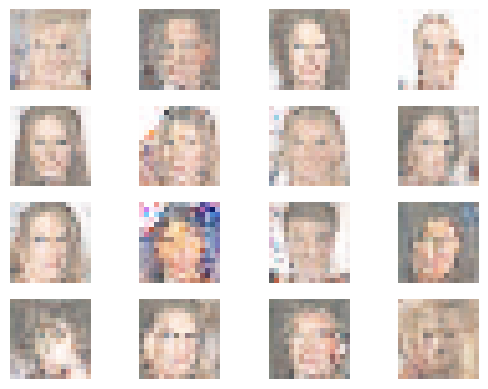

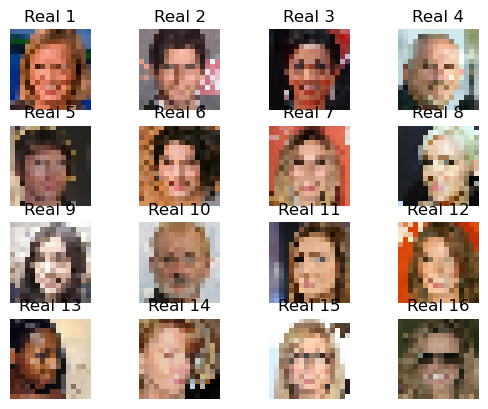

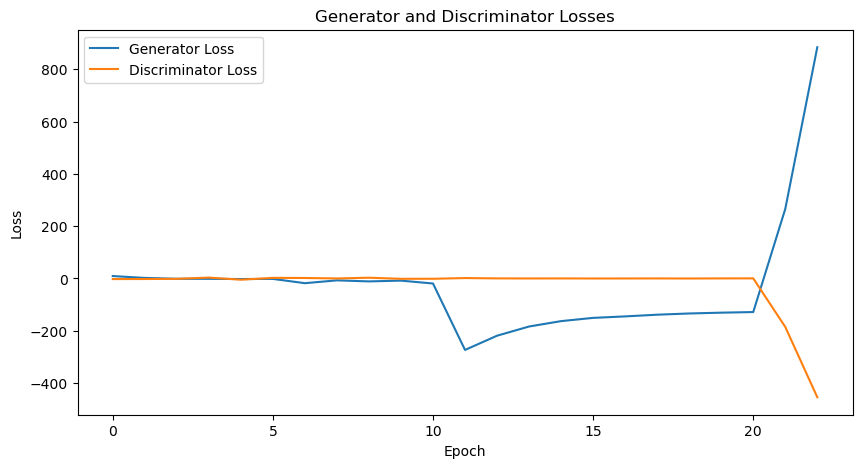

100%|██████████| 1875/1875 [01:22<00:00, 22.82it/s]


EPOCH 23 || GENERATOR LOSS: 577.0914916992188 || DISCRIMINATOR LOSS: -1057.89697265625


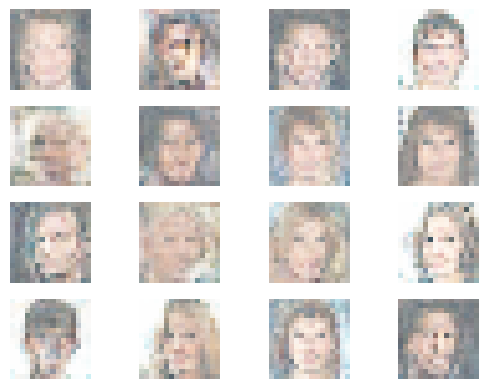

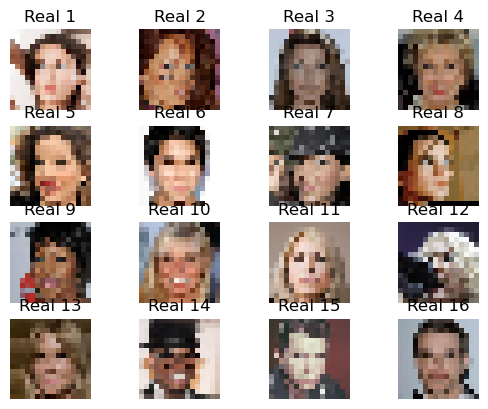

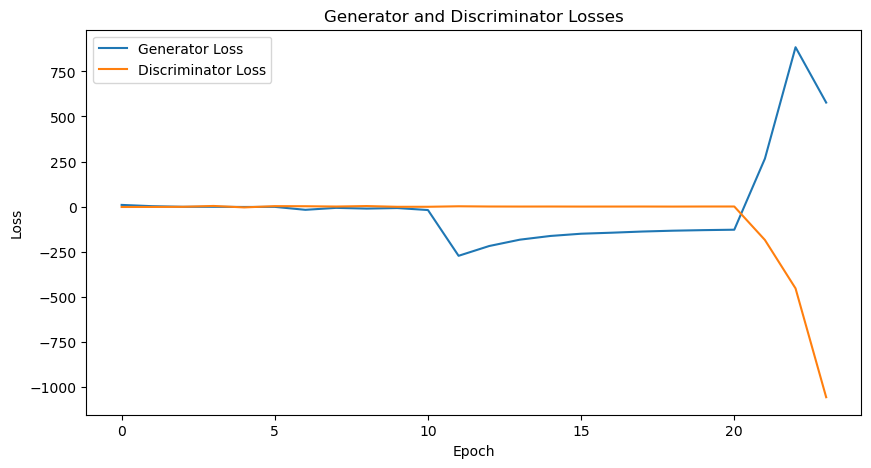

100%|██████████| 1875/1875 [01:22<00:00, 22.76it/s]


EPOCH 24 || GENERATOR LOSS: 1431.376220703125 || DISCRIMINATOR LOSS: -395.8997802734375


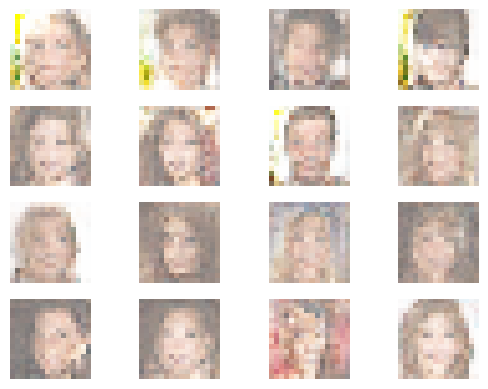

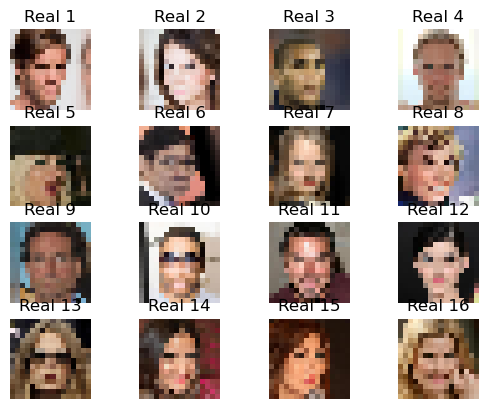

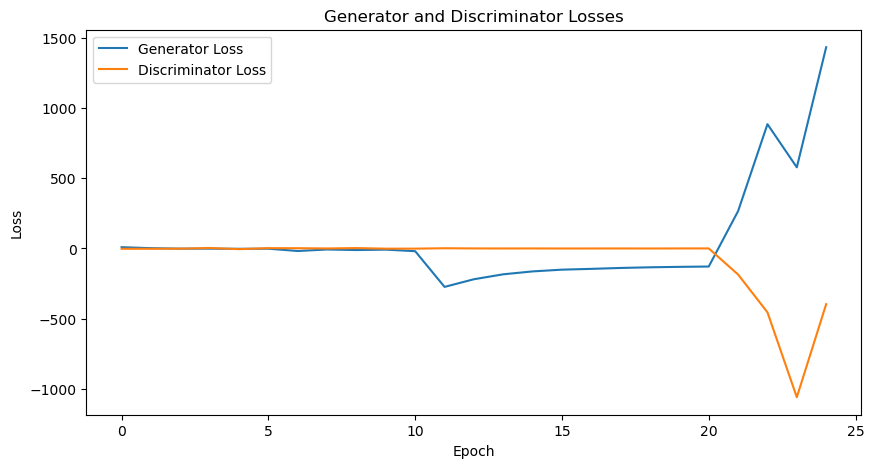

100%|██████████| 1875/1875 [01:22<00:00, 22.72it/s]


EPOCH 25 || GENERATOR LOSS: 72.07928466796875 || DISCRIMINATOR LOSS: -2235.800048828125


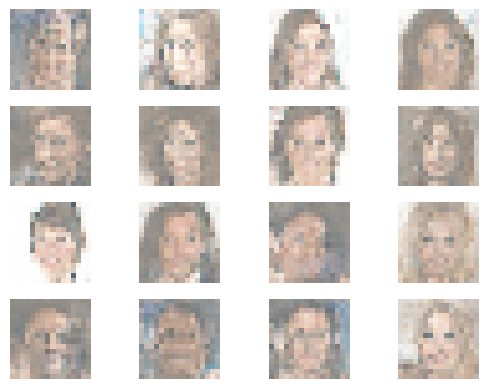

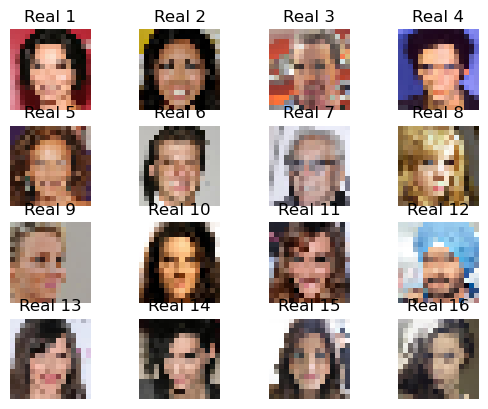

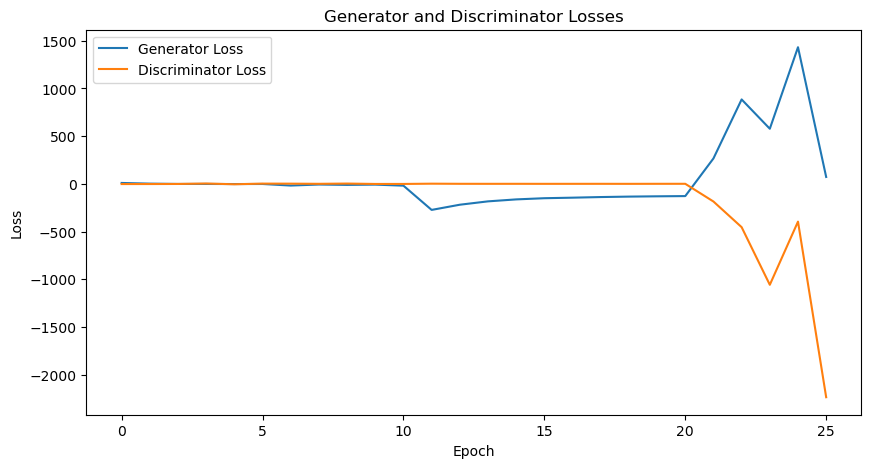

100%|██████████| 1875/1875 [01:22<00:00, 22.70it/s]


EPOCH 26 || GENERATOR LOSS: 315.3401184082031 || DISCRIMINATOR LOSS: -1939.052978515625


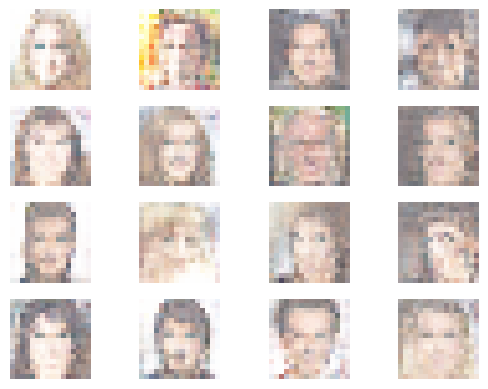

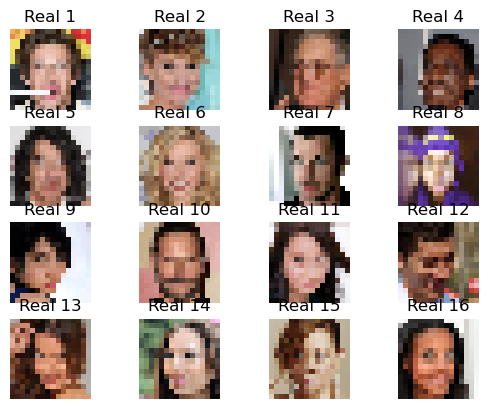

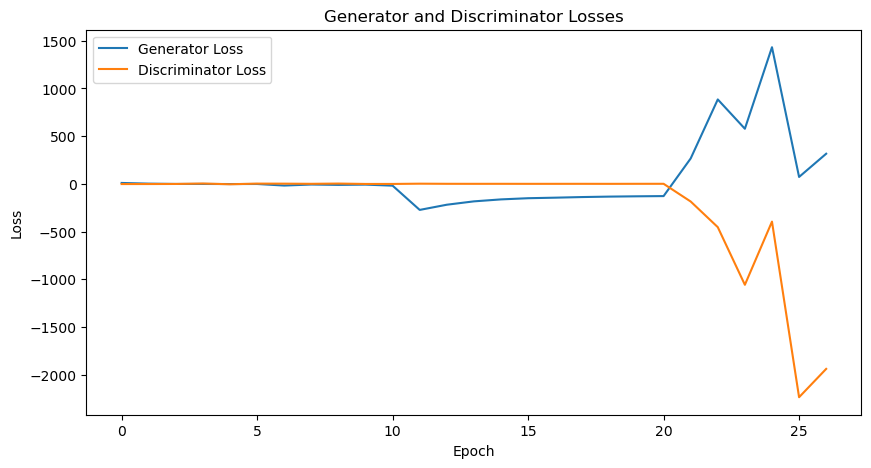

100%|██████████| 1875/1875 [01:25<00:00, 21.83it/s]


EPOCH 27 || GENERATOR LOSS: 2256.339111328125 || DISCRIMINATOR LOSS: -3382.325439453125


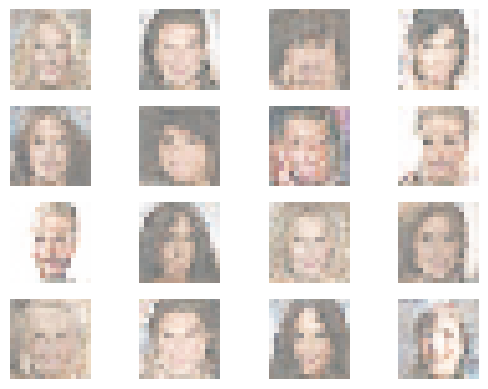

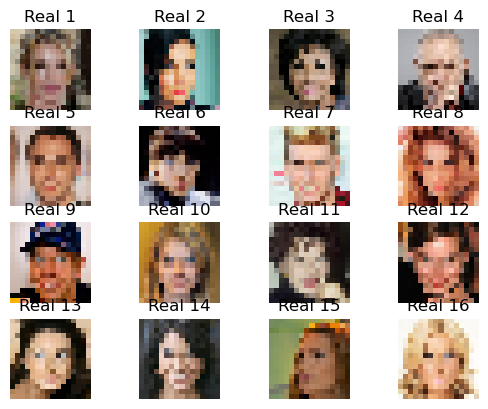

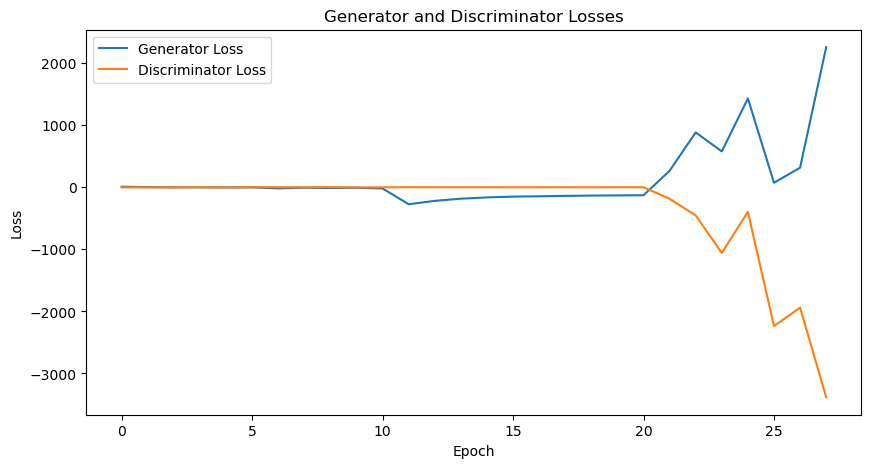

100%|██████████| 1875/1875 [01:23<00:00, 22.47it/s]


EPOCH 28 || GENERATOR LOSS: 1967.6533203125 || DISCRIMINATOR LOSS: -925.24072265625


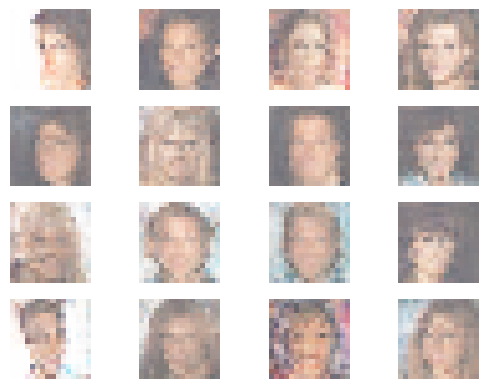

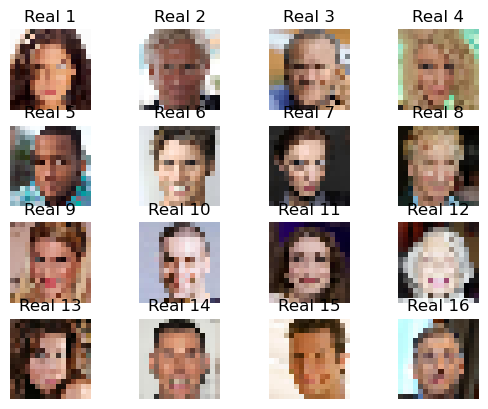

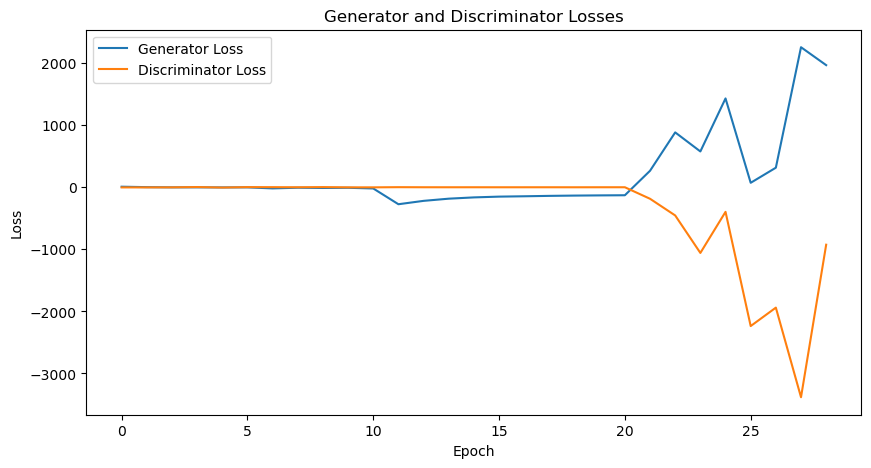

100%|██████████| 1875/1875 [01:23<00:00, 22.56it/s]


EPOCH 29 || GENERATOR LOSS: 1569.25732421875 || DISCRIMINATOR LOSS: -5877.49169921875


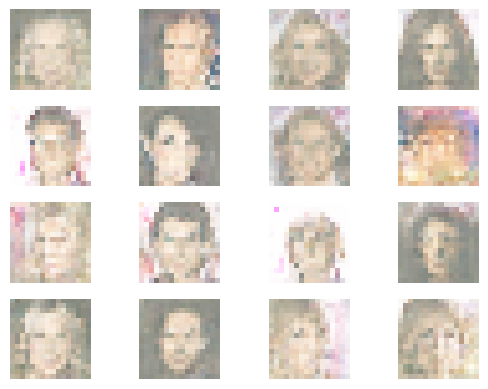

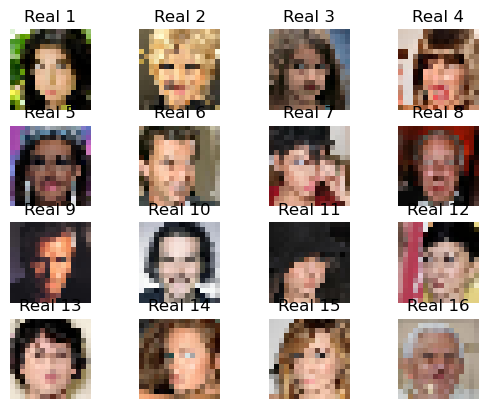

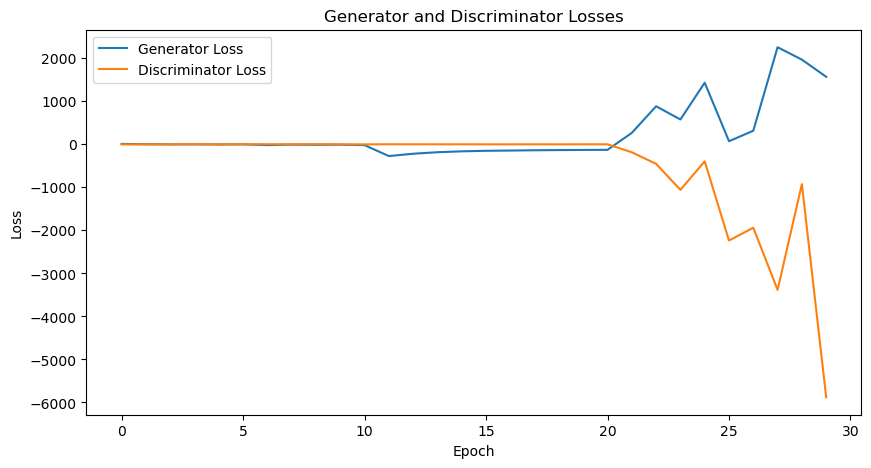

100%|██████████| 1875/1875 [01:25<00:00, 21.97it/s]


EPOCH 30 || GENERATOR LOSS: 485.60113525390625 || DISCRIMINATOR LOSS: -6076.125


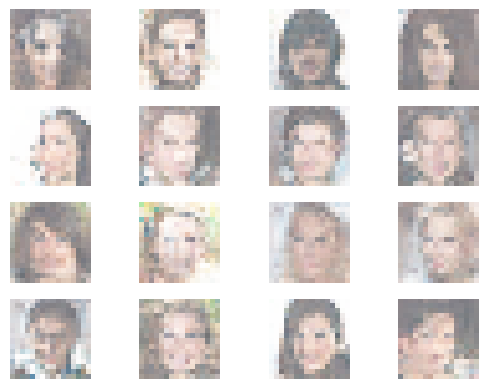

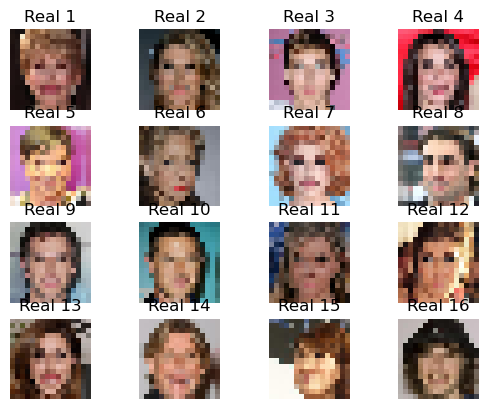

EXTENDED


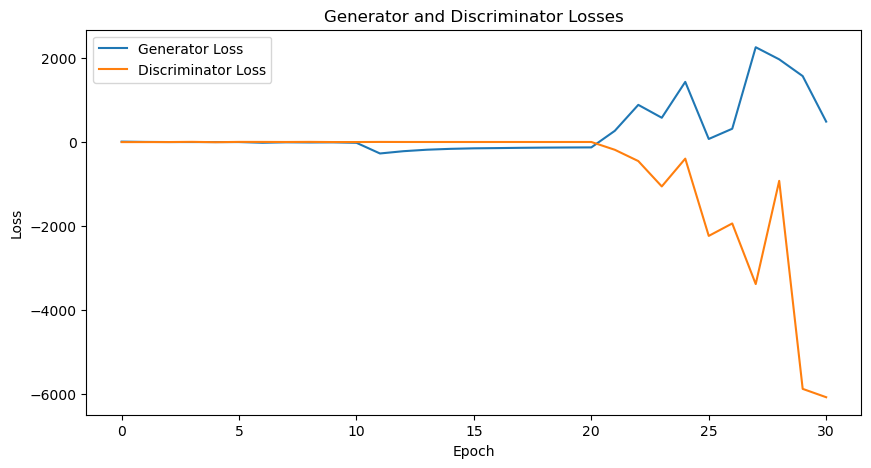

100%|██████████| 1875/1875 [02:37<00:00, 11.93it/s]


EPOCH 31 || GENERATOR LOSS: -355.62451171875 || DISCRIMINATOR LOSS: -4210.189453125


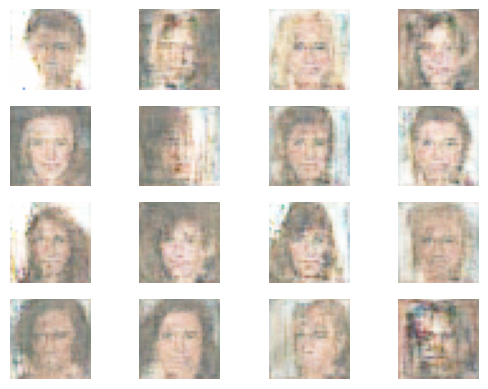

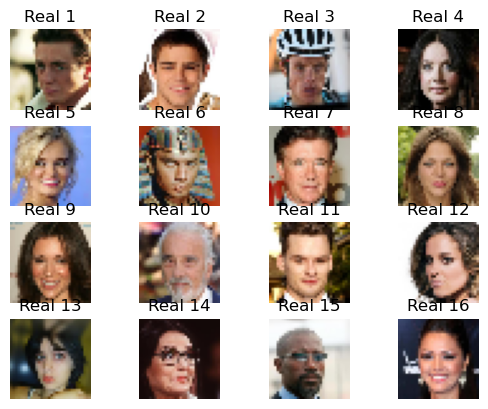

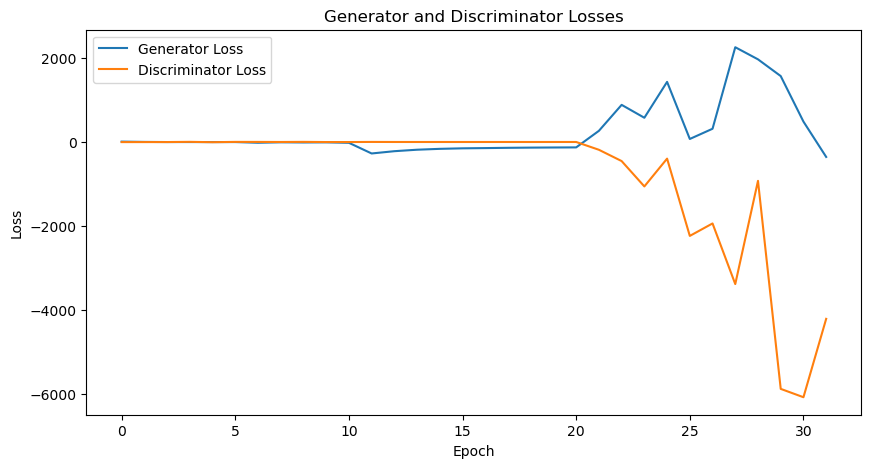

100%|██████████| 1875/1875 [02:46<00:00, 11.25it/s]


EPOCH 32 || GENERATOR LOSS: 6340.44482421875 || DISCRIMINATOR LOSS: -4056.20556640625


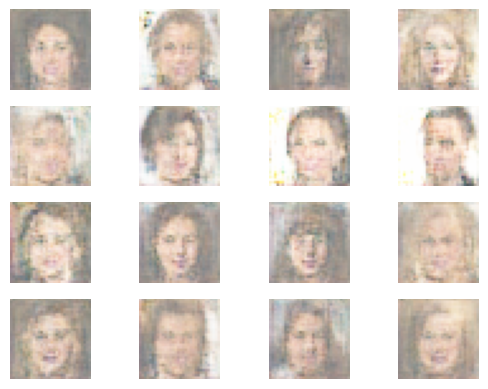

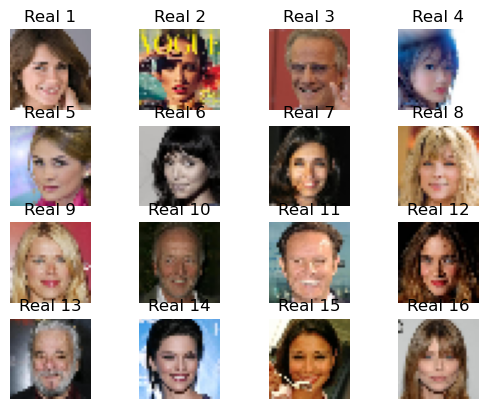

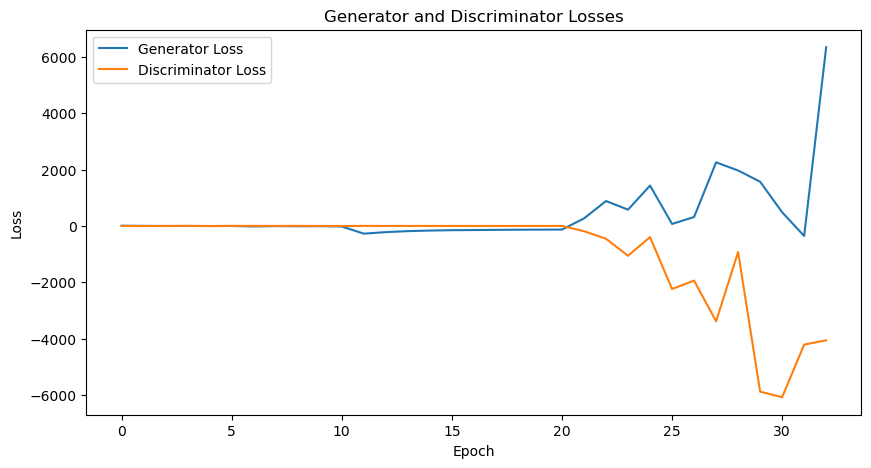

100%|██████████| 1875/1875 [02:52<00:00, 10.85it/s]


EPOCH 33 || GENERATOR LOSS: 8978.927734375 || DISCRIMINATOR LOSS: -11264.357421875


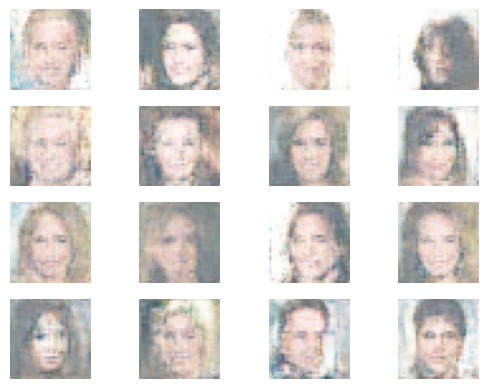

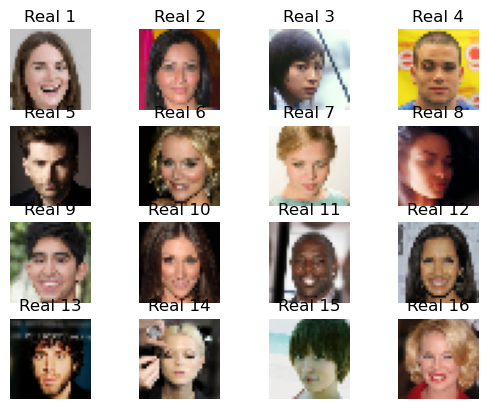

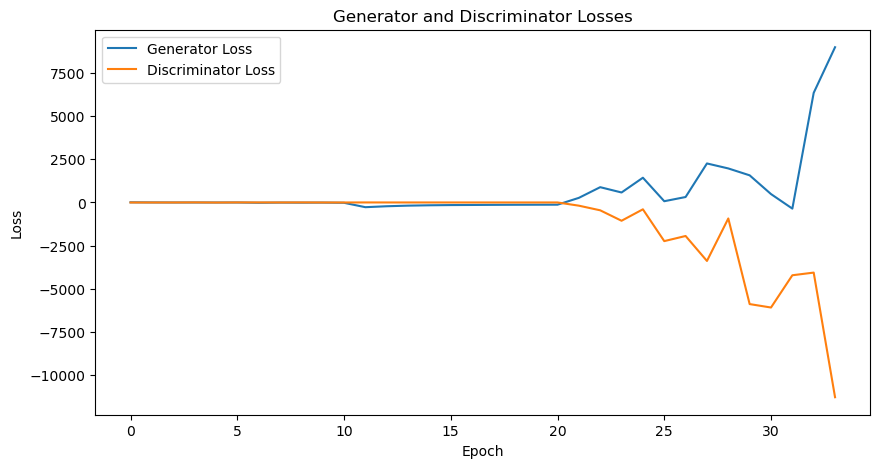

100%|██████████| 1875/1875 [02:52<00:00, 10.86it/s]


EPOCH 34 || GENERATOR LOSS: 6239.95166015625 || DISCRIMINATOR LOSS: -10967.349609375


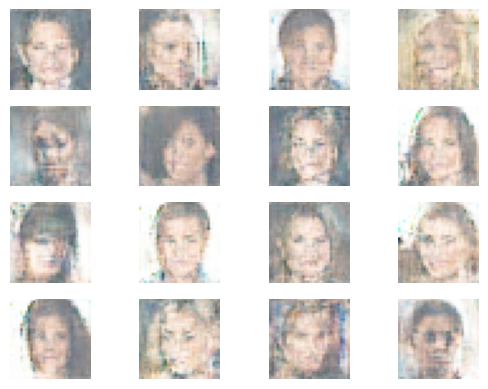

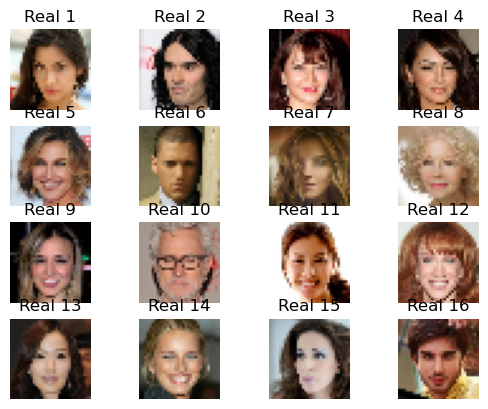

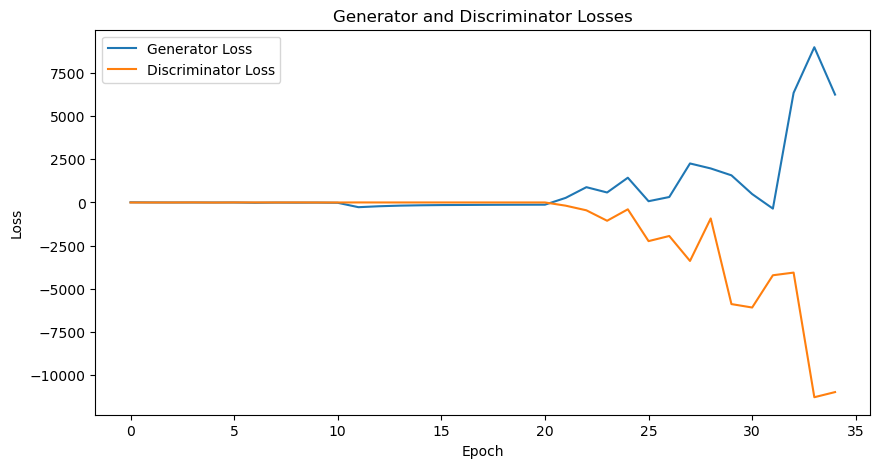

  4%|▍         | 79/1875 [00:07<02:56, 10.19it/s]


KeyboardInterrupt: 

In [35]:
pgan.train()